# Аналитическое исследование

***Заказчик***. 
Компания Devim

***Задача***
Проанализировать характер поведения клиентов с точки зрения просрочки, ответив на вопросы:
- какова динамика просрочки?
- тенденция к снижению или увеличению?

***Описание данных*** 
Работать предстоит с 3 датасетами:
1. ***orders.csv*** содержит данные: 
   - order_id (номер заявки)
   - created_at (дата создания заявки)
   - put_at (дата выдачи)
   - closed_at (дата закрытия)
   - issued_sum (сумма выдачи)
2. ***payment.csv*** содержит данные: 
   - order_id (номер заявки)
   - paid_at (дата фактического платежа)
   - paid_sum (сумма фактического платежа)
3. ***plan.csv*** содержит данные: 
   - order_id (номер заявки)
   - plan_at (дата планового платежа)
   - plan_sum_total (сумма планового платежа (накопленным итогом))

## 1.1. Загрузка бибилиотек и знакомство с данными

In [4]:
#необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from IPython.display import display

#снимаем ограничения на ширину строк и столбцов, а также их количество при выведении на экран
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

#улучшим качество графиков
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 6]

#игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [5]:
#загружаем датасеты в переменные, просматриваем описанием данных датасета и смотрим на первые строки
def load_and_display_datasets():

    orders = pd.read_csv('/Users/ksusharusak/Documents/Devim/Дата/orders.csv')
    payment = pd.read_csv('/Users/ksusharusak/Documents/Devim/Дата/payments.csv')
    plan = pd.read_csv('/Users/ksusharusak/Documents/Devim/Дата/plan.csv')

    print("Информация о датасете orders:")
    orders.info()
    print(orders.head())  

    print("\nИнформация о датасете payment:")
    payment.info()
    print(payment.head())

    print("\nИнформация о датасете plan:")
    plan.info()
    print(plan.head())

    return orders, payment, plan  

orders, payment, plan = load_and_display_datasets()

Информация о датасете orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB
    order_id               created_at                   put_at  \
0  400001732  2022-06-02 00:00:23.997  2022-06-02 20:18:00.180   
1  400005838  2022-06-02 00:10:22.997  2022-06-02 15:41:33.267   
2  400007915  2022-06-02 00:18:04.000  2022-06-05 19:17:38.547   
3  400008952  2022-06-02 00:22:07.000  2022-06-03 14:25:18.033   
4  400009027  2022-06-02 00:25:39.000  2022-06-02 00:40:40.320   

                 closed_at  issued_sum  
0  2022-10-17 11:52:22.190     13600.0  
1  2022-06-02 17:38:43.917     200

## 2. Предобработка данных

### 2.1. Изменение типов данных в столбцах

Изменим формат данных на DateTime c object во всех столбцах где указаны временные параметры.

In [9]:
#изменение типа данных в столбцах с указанием даты и времени таблицы orders
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['put_at'] = pd.to_datetime(orders['put_at'])
orders['closed_at'] = pd.to_datetime(orders['closed_at'])

#изменение типа данных в столбцах с указанием даты и времени таблицы payment
payment['paid_at'] = pd.to_datetime(payment['paid_at'])

#изменение типа данных в столбцах с указанием даты и времени таблицы plan
plan['plan_at'] = pd.to_datetime(plan['plan_at'])

Также посмотрим на промежуток времени в который выдавались кредиты и поступали фактические платежи.

In [11]:
#минимальная и максимальная даты для created_at (дата заявки)
min_created_date = orders['created_at'].min()
max_created_date = orders['created_at'].max()

#минимальная и максимальная даты для put_at (дата выдачи)
min_put_at_date = orders['put_at'].min()
max_put_at_date = orders['put_at'].max()

#минимальная и максимальная даты для payment_date (игнорируя NaN)
min_payment_date = payment['paid_at'].min()
max_payment_date = payment['paid_at'].max()

print(f"Минимальная дата создания заявки: {min_created_date}")
print(f"Максимальная дата создания заявки: {max_created_date}")
print(f"Минимальная дата выдачи кредита: {min_put_at_date}")
print(f"Максимальная дата выдачи кредита: {max_put_at_date}")
print(f"Минимальная дата внесения платежа: {min_payment_date}")
print(f"Максимальная дата внесения платежа: {max_payment_date}")

Минимальная дата создания заявки: 2022-06-02 00:00:23.997000
Максимальная дата создания заявки: 2022-08-31 23:49:42.997000
Минимальная дата выдачи кредита: 2022-06-02 00:40:40.320000
Максимальная дата выдачи кредита: 2022-09-29 18:46:58.387000
Минимальная дата внесения платежа: 2022-06-02 00:48:13.800000
Максимальная дата внесения платежа: 2022-12-08 13:28:23.703000


## 2.2. Проверка наличия явных дубликатов

Проверим датасеты на явные дубликаты и выведем на экран дублирующиеся строки в случае их наличия.

In [14]:
def check_duplicates(dfs, names):

    duplicates_info = {}
    
    for df, name in zip(dfs, names):
       
        duplicate_count = df.duplicated().sum()
        duplicates_info[name] = duplicate_count
        
        if duplicate_count > 0:
            print(f'В {name} найдено {duplicate_count} явных дубликатов.')
            print(df[df.duplicated(keep=False)]) 
        else:
            print(f'В {name} дубликатов не найдено.')
    
    return duplicates_info
    
check_duplicates([orders, payment, plan], ['orders', 'payment', 'plan'])

В orders дубликатов не найдено.
В payment найдено 5 явных дубликатов.
         order_id                 paid_at  paid_sum
11474   411504997 2022-06-24 17:14:56.997   10100.0
11475   411504997 2022-06-24 17:14:56.997   10100.0
12469   422632789 2022-06-25 23:16:16.000    8080.0
12470   422632789 2022-06-25 23:16:16.000    8080.0
37758   432761640 2022-07-21 12:38:12.000     150.0
37759   432761640 2022-07-21 12:38:12.000     150.0
38413   420036980 2022-07-21 20:08:58.997    4800.0
38414   420036980 2022-07-21 20:08:58.997    4800.0
139589  456075017 2022-11-22 19:44:08.793    2720.0
139590  456075017 2022-11-22 19:44:08.793    2720.0
В plan дубликатов не найдено.


{'orders': 0, 'payment': 5, 'plan': 0}

In [15]:
# удалим явные дубликаты из таблицы payment
payment = payment.drop_duplicates()

### 2.3. Обработка пропущенных значений

При знакомстве с данными наличие пропусков зафиксировано в таблице orders. Посмотрим на объем пропущенных значений

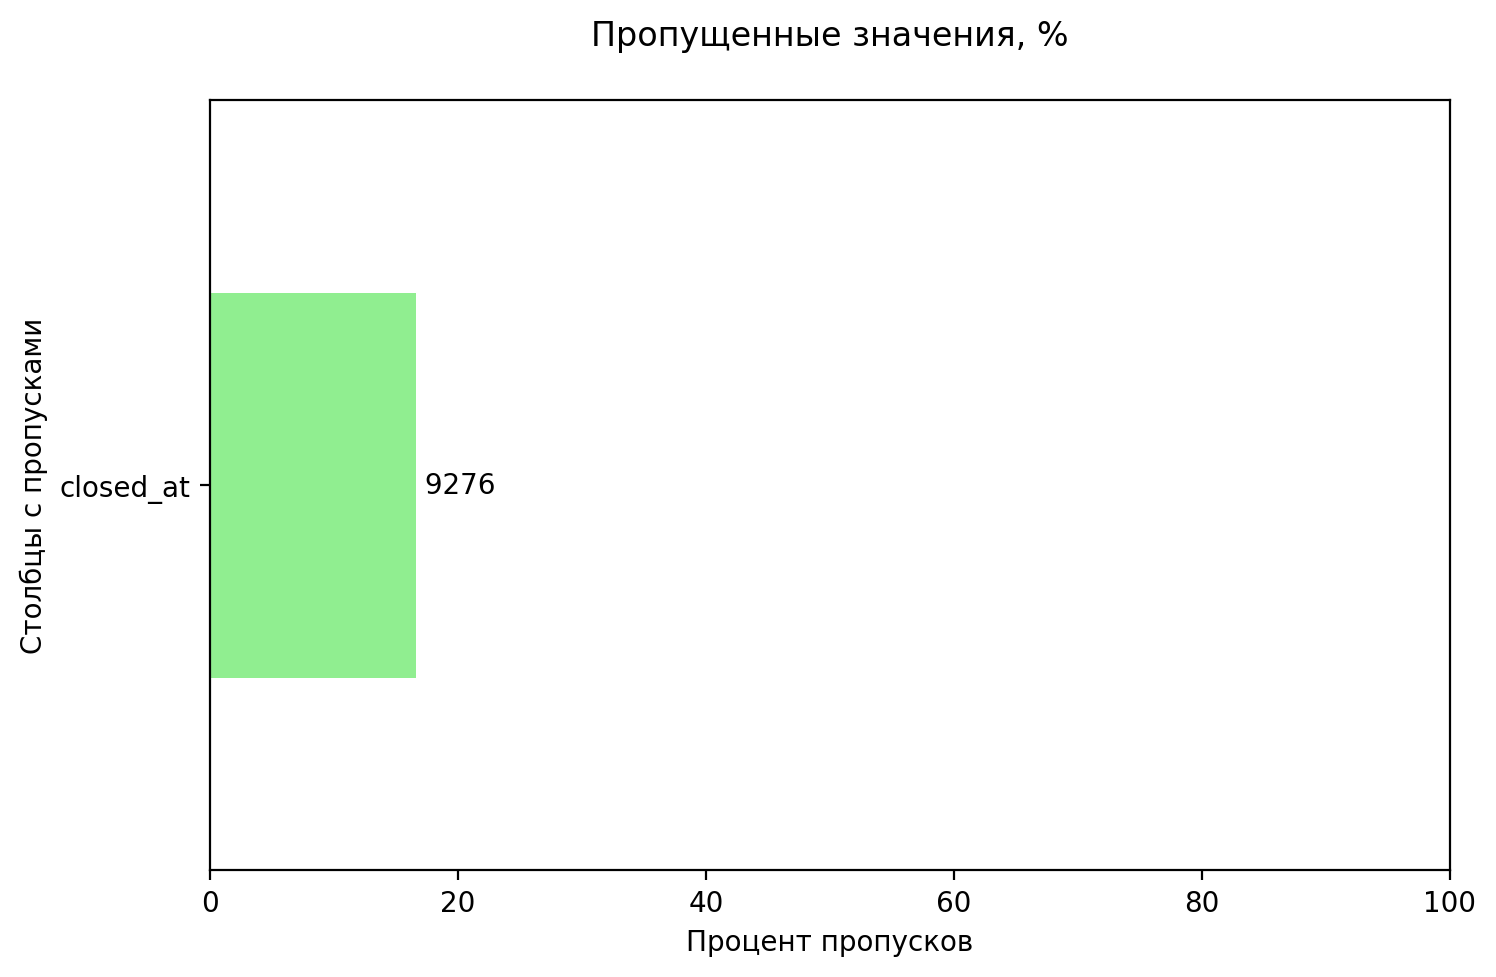

In [18]:
def pass_value_barh(data):
    try:
        missing_values = data.isna().sum()
        missing_percentage = (data.isna().mean() * 100).to_frame().rename(columns={0: 'space'})
        
        missing_info = pd.DataFrame({
            'count': missing_values,
            'percentage': missing_percentage['space']
        })
        missing_info = missing_info[missing_info['count'] > 0].sort_values(by='percentage', ascending=True)

        
        missing_info['percentage'].plot(kind='barh', figsize=(8, 5), legend=False, color='lightgreen')
        
        plt.title('Пропущенные значения, %' + "\n", fontsize=12)
        plt.xlabel('Процент пропусков', fontsize=10)
        plt.ylabel('Столбцы с пропусками', fontsize=10)
        plt.xlim(0, 100)

        for index, value in enumerate(missing_info['count']):
            plt.text(missing_info['percentage'].iloc[index], index, f' {value}', va='center')

    except Exception as e:
        print('Пропусков нет или произошла ошибка:', e)

pass_value_barh(orders)

Отсутствие информации о дате закрытия кредита говорит о том, что либо кредит не являтся закрытым, либо об ошибке в выгрузке данных. Удаление всех наблюдений с пропускам не желательно, так как это чуть больше 16% от общего объема данных таблицы orders. 

Проверми откуда появились пропуски. Так как мы знаем, что данные у нас действительны на 8 декабря 2022 года, эти пропуски могут говорить о том, что дата планового закрытия кредита еще не наступила.

Для удобства добавим новый столбец в таблицу orders со статусом кредита и назовем credit_status. Начнем с тех кредитов у которых проставлена дата закрытия и присвоим тип "закрыт", в остальных случаях пока проставим статус "просрочка".

In [20]:
orders['credit_status'] = orders['closed_at'].apply(lambda x: 'закрыт' if pd.notnull(x) else 'просрочка')

Теперь нам нужно сверить кредиты с отсуствующей информацией о закрытии с таблицей plan. Выведем масимальную (последнюю) дату планового платежа для каждой заявки. Все кредиты с датами закрытия после 8 декабря 2022 года, запишем в категорию "в процессе выплаты".

In [22]:
#последняя плановая дата выпат по кредитам для каждой заявки
max_dates = plan.groupby('order_id')['plan_at'].max().reset_index()

#сравнение с датой на которую у нас актуальная информация
comparison_date = pd.to_datetime('2022-12-08')

#фильтруем те заявки у которых дата закрытия еще не наступила
filtered_max_dates = max_dates[max_dates['plan_at'] > comparison_date]

#получаем id заявок у которых в столбце с датой закрытия стоит пропуск
orders_with_missing_closed_at = orders[orders['closed_at'].isnull()]

#объедияем filtered_max_dates для получения статусов
result = orders_with_missing_closed_at.merge(filtered_max_dates[['order_id']], on='order_id', how='inner')

#обновим credit_status в таблице orders
orders.loc[orders['order_id'].isin(result['order_id']), 'credit_status'] = 'в процессе выплаты'

#проверяем результат
orders.tail()

,order_id,created_at,put_at,closed_at,issued_sum,credit_status
55743,495174013,2022-08-31 23:29:32.000,2022-09-01 00:07:26.307,NaT,9500.0,в процессе выплаты
55744,495174505,2022-08-31 23:41:57.997,2022-09-05 17:51:19.003,2022-09-16 18:36:09.857,14930.0,закрыт
55745,495175322,2022-08-31 23:46:04.997,2022-09-01 00:03:52.010,2022-09-09 21:08:18.970,4000.0,закрыт
55746,495176080,2022-08-31 23:47:20.997,2022-08-31 23:49:03.027,2022-09-12 00:58:57.037,5000.0,закрыт
55747,495177509,2022-08-31 23:49:42.997,2022-09-01 05:50:06.663,NaT,27130.0,в процессе выплаты


In [23]:
#считаем количество кредитов в каждом и проставленных статусов
count_credit_status = orders.groupby('credit_status')['order_id'].agg('count').reset_index()
total_orders = orders['order_id'].count()

#добавляем столбец с процентным соотношением
count_credit_status['percentage'] = (count_credit_status['order_id'] / total_orders * 100).round(2)
count_credit_status['percentage'] = count_credit_status['percentage'].astype(str) + '%'

count_credit_status  

,credit_status,order_id,percentage
0,в процессе выплаты,8147,14.61%
1,закрыт,46472,83.36%
2,просрочка,1129,2.03%


Изначально в датасете было 9276 пропущенных значений с отсустсующей датой закрытия кредита. Детализировав пропуски стало понятно, что из них 8147 это кредиты у который дата закрытия еще не наступила и 1129 кредитов не закрыты в срок, то есть являются просрочкой. 
Так как пропуски образованы по разным причинам заполнять их единым значениме не будем. При необходимость воспользуемся новым столбцом credit_status.

## 2.4. Уникальные значения

In [26]:
# Посмотрим на коичество уникальных идентификаторов заявок в таблице orders
orders['order_id'].nunique()

55748

In [27]:
# Посмотрим на коичество уникальных идентификаторов заявок в таблице plan
plan['order_id'].nunique()

55748

In [28]:
# Посмотрим на коичество уникальных идентификаторов заявок в таблице payment
payment['order_id'].nunique()

53730

Cравним идентификаторы заявок на кредит, данные в таблицах соответствуют одним и тем же заявкам.

In [30]:
#получаем уникальные order_id из каждой таблицы
orders_ids = set(orders['order_id'].unique())
plan_ids = set(plan['order_id'].unique())

# Находим пересечения и различия
common_ids = orders_ids & plan_ids        # ID, присутствующие в обеих таблицах
unique_to_orders = orders_ids - plan_ids  # ID, которые есть только в orders
unique_to_plan = plan_ids - orders_ids    # ID, которые есть только в plan

#отображение в формате таблицы
comparison = pd.DataFrame({
    'Тип сравнения': [
        'Общие order_id (присутствуют в обеих таблицах)',
        'Уникальные для orders',
        'Уникальные для plan'
    ],
    'Количество': [
        len(common_ids),
        len(unique_to_orders),
        len(unique_to_plan)
    ],
    'Примеры ID': [
        list(common_ids)[:3] if common_ids else [],
        list(unique_to_orders)[:3] if unique_to_orders else [],
        list(unique_to_plan)[:3] if unique_to_plan else []
    ]
})

display(comparison)

,Тип сравнения,Количество,Примеры ID
0,Общие order_id (присутствуют в обеих таблицах),55748,"[464257025, 448921602, 442499077]"
1,Уникальные для orders,0,[]
2,Уникальные для plan,0,[]


В таблицах order_id и plan количество уникальных id заявок совпадает и это одни и те же заявки. Но вот в таблице payment на 2018 id меньше. Это может указывать, что по 2018 заявкам платежи не были внесены ни разу. Проверим, отфильтруем order_id отсутствующие в payment и посмотрим на статусы этих кредитов. 

In [32]:
merged = orders.merge(payment[['order_id']], on='order_id', how='left', indicator=True)

# фильтруем order_id, которые есть в orders и отсутствуют в payments
missing_payment = merged[merged['_merge'] == 'left_only']

missing_payment[['order_id', 'created_at', 'put_at', 'closed_at', 'issued_sum', 'credit_status']]
count_status = missing_payment.groupby('credit_status')['order_id'].agg('count').reset_index()
count_status

,credit_status,order_id
0,в процессе выплаты,1448
1,закрыт,2
2,просрочка,568


Есть 2 закрытых кредита, по которым якобы не поступало ни одного платежа. Посмотрим на плановые даты взносов по этим заявкам.

In [34]:
missing_payment[missing_payment['credit_status'] == 'закрыт']

,order_id,created_at,put_at,closed_at,issued_sum,credit_status,_merge
100839,465402852,2022-08-03 15:58:41,2022-08-13 17:40:26.047,2022-08-13,2000.0,закрыт,left_only
110538,471890947,2022-08-09 18:11:02,2022-09-01 14:14:17.930,2022-09-09,1000.0,закрыт,left_only


In [35]:
plan[plan['order_id'] == 465402852]

,order_id,plan_at,plan_sum_total
286972,465402852,2022-09-05,0.0


In [36]:
plan[plan['order_id'] == 471890947]

,order_id,plan_at,plan_sum_total
314603,471890947,2022-09-16,1150.0


Оба кредита были закрыты еще до наступления даты первого планового платежа, причем один с id 465402852 закрыл кредит в день выдачи, второй id 471890947 в тчение 8 дней, поэтому они не попали в таблицу payment. Так как это достаточно редкий случай для наших данных удалим эти наблюдения из всех датасетов.

In [38]:
#id заявок которые удаляем из датасетов
order_ids_to_remove = [465402852, 471890947]

# удаляем строки с указанными order_id для датасетов orders и plan
orders = orders[~orders['order_id'].isin(order_ids_to_remove)]
plan = plan[~plan['order_id'].isin(order_ids_to_remove)]

Во избежание ошибоко в данных проверим были ли фактические платежи с орицательной или нулевой суммой.

In [40]:
#проверка фактических и плановых платежей с нулевой суммой
payment[payment['paid_sum'] <= 0]

,order_id,paid_at,paid_sum


После удаления данных проверим количество кредитов по статусам перед анализом.

In [42]:
#считаем количество кредитов в каждом и проставленных статусов
count_credit_status = orders.groupby('credit_status')['order_id'].agg('count').reset_index()
total_orders = orders['order_id'].count()

#добавляем столбец с процентным соотношением
count_credit_status['percentage'] = (count_credit_status['order_id'] / total_orders * 100).round(2)
count_credit_status['percentage'] = count_credit_status['percentage'].astype(str) + '%'

count_credit_status  

,credit_status,order_id,percentage
0,в процессе выплаты,8147,14.61%
1,закрыт,46470,83.36%
2,просрочка,1129,2.03%


## 2.5. Добавление дополнительных столбцов

Так как в дальнейшем анализе нам предстоит оценивать динамику просрочек, стоить добавить к датасетам столбцы с указанием месяца.

In [45]:
#добавление столбца с месяцем выдачи кредита в таблице orders и преобразуем полученнцю дату в timestamp
orders['month_issue'] = orders['put_at'].dt.to_period('M')
orders['month_issue'] = orders['month_issue'].dt.to_timestamp()

#добавление столбца с месяцем получения заявки на кредит в таблице orders и преобразуем полученнцю дату в timestamp
orders['month_creation'] = orders['created_at'].dt.to_period('M')
orders['month_creation'] = orders['month_creation'].dt.to_timestamp()

In [46]:
#добавление столбца с месяцем планового платежа в таблице plan и преобразуем полученнцю дату в timestamp
plan['month_plan_at'] = plan['plan_at'].dt.to_period('M')
plan['month_plan_at'] = plan['month_plan_at'].dt.to_timestamp()

In [47]:
#добавление столбца с месяцем фактического платежа в таблице payment и преобразуем полученнцю дату в timestamp
payment['month_paid_at'] = payment['paid_at'].dt.to_period('M')
payment['month_paid_at'] = payment['month_paid_at'].dt.to_timestamp()

## Промежуточный вывод

В процессе предобработки данных выполнены следующие шаги:

1. Изменен тип данных в столбцах с временными параметрами c object на datetime:
- в таблице orders это столбцы created_at, put_at, closed_at
- в таблице payment это столбец paid_at
- в таблице plan это столбец plan

2. Выявлено 5 строк с явными дубликатами в таблице payment и удалены из дальнейшего анализа

3. Пропуски в данных обнаружены в таблице orders в столбце closed_at 9276. После сверки с датасетов plan кредитным заявкам присвоен статус в таблице orders столбец credit_type:
- 'закрыт' - если указана дата закрытия кредита
- 'в процессе выплаты'  - если срок последнего платежа еще не наступил, то есть запланирован после 8 декабря 2022 года
- 'просрочка' - если дата последнего платежа наступила, но кредит не был закрыт.

4. Всего в полученных датасетах информация о 55748 заявках на кредит поступивших с 2 июня 2022 года по 31 августа 2022 года, что совпдает с количеством уникальных id заявок в таблице plan. Однако обнаружено, что исходя из данных таблицы payment по 2018 кредитам платежей не поступало в принципе. Из 2018 кредитов 2 оказалис уже закрытыми, обобщает эти 2 случая то, что закрытие кредитов произошло до наступления даты 1ого планового платежа, поэтому было принято рещение удалить наблюдения по этим id из всех датасетов.
   
5. Добавлены столбцы с указанием месяца для каждого датасета:
- в таблицу orders добавлены столбцы month_creation и month_issue с месяцев создания заявки и месяце выдачи кредита;
- в таблицу plan добавлены столбец month_plan_at с месяцем ожидаемого планового платежа;
- в таблицу payment добавлены столбец month_paid_at с месяцем опоступления фактического платежа.

Приступая в анализу данных мы имеем:
- 55746 заявок на кредит из которых 46470 в статусе закрыт, 8147 в процессе выплаты и 1129 у которых истекла дата последнго платежа.
- 2016 заявок по которым не зафиксировано ни одного платежа.

## Исследовательский анализ данных

### 2.1. Количество выданных кредитов, сумма кредитов и заявок по месяцам

Посчитаем количество выданных кредитов по месяцам  и сохраним в переменной issued_orders.

In [53]:
issued_orders = orders.groupby('month_issue')['order_id'].agg('count').reset_index()
issued_orders.columns = ['month_issue','count_orders']

issued_orders

,month_issue,count_orders
0,2022-06-01,15899
1,2022-07-01,19085
2,2022-08-01,19330
3,2022-09-01,1432


Посмтроим график исходя из полученной таблицы issued_orders.

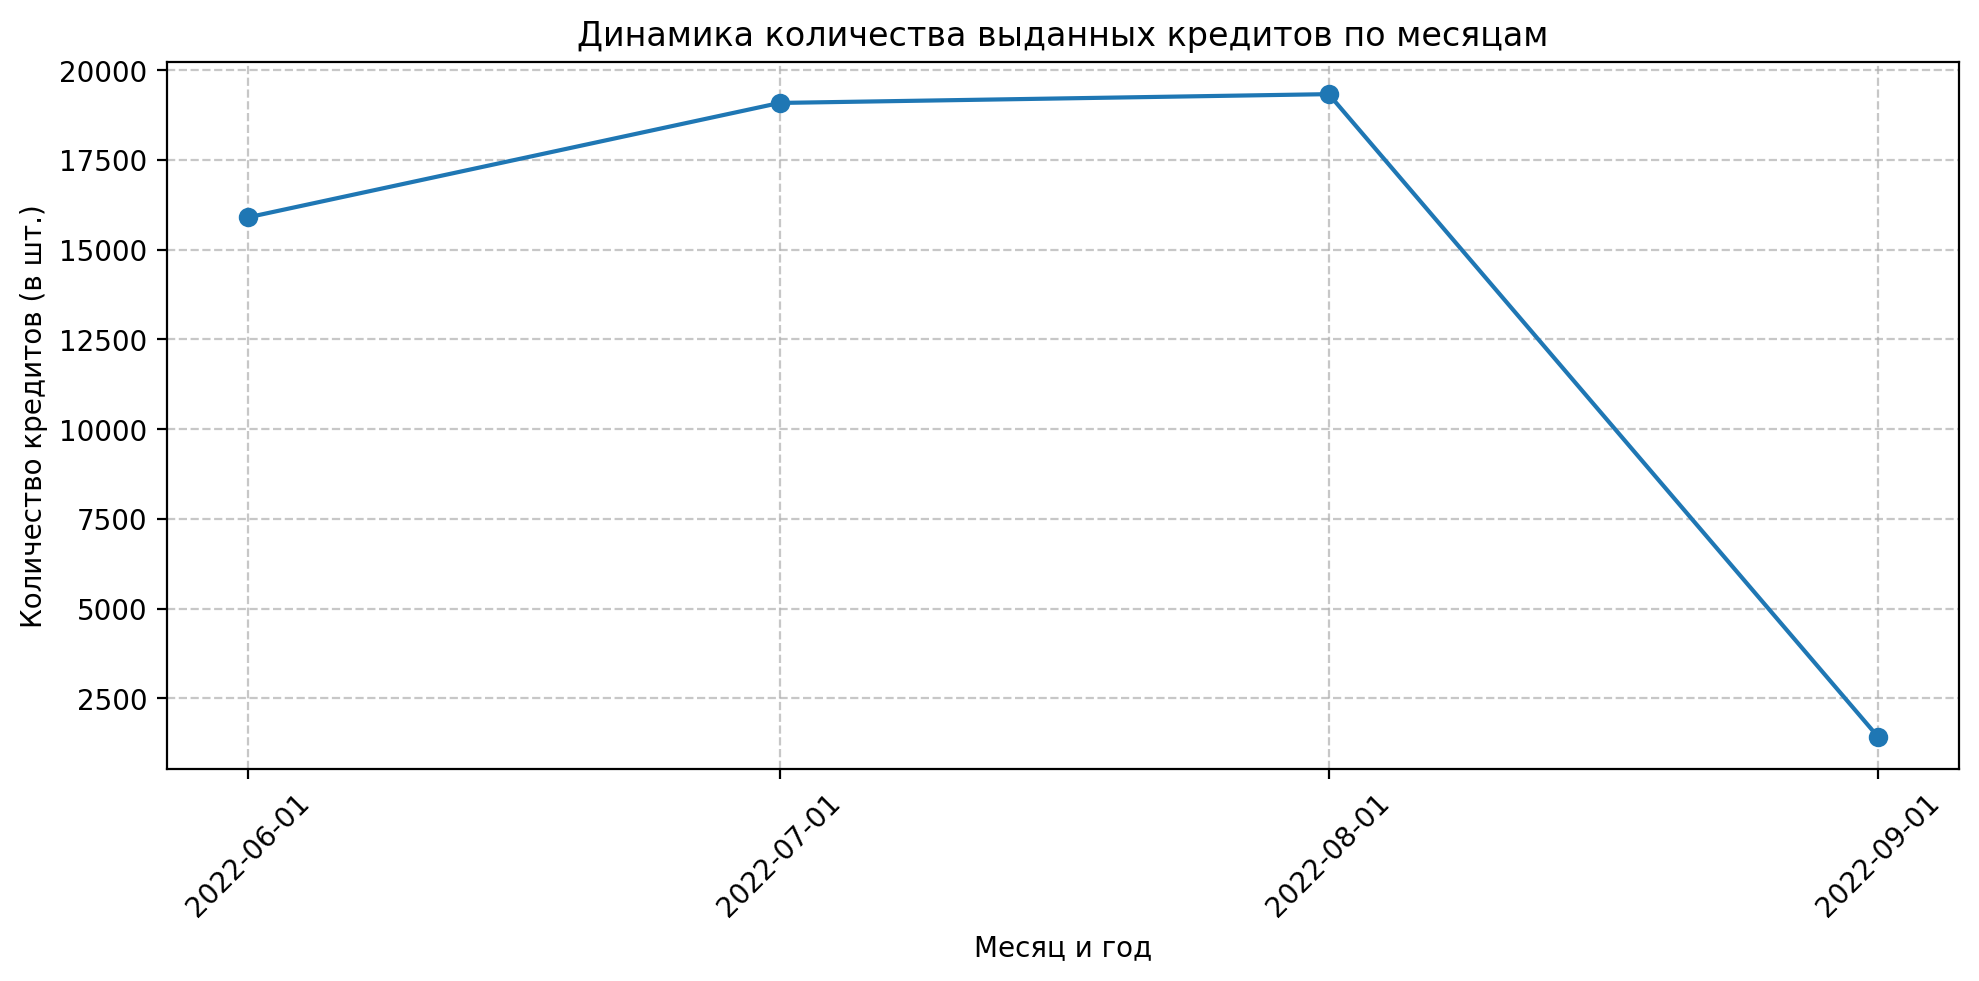

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(issued_orders['month_issue'], issued_orders['count_orders'], marker='o')

plt.title('Динамика количества выданных кредитов по месяцам', fontsize = 12)
plt.xlabel('Месяц и год')
plt.ylabel('Количество кредитов (в шт.)')
plt.xticks(issued_orders['month_issue'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Выдавались кредиты  наблюдается тенденция к снижению количества выданных кредитов в сентябре, снижение резкое, поэтому посмотрим отличаются ли суммы выданных кредитов по месяцам.

In [57]:
sum_issued_orders = orders.groupby('month_issue')['issued_sum'].agg('sum').reset_index()
sum_issued_orders.columns = ['month_issue','monthly_issued_sum']

#делим на миллион для упрощения визуального восприятия
sum_issued_orders['monthly_issued_sum'] = sum_issued_orders['monthly_issued_sum']/1000000

sum_issued_orders

,month_issue,monthly_issued_sum
0,2022-06-01,124.58911
1,2022-07-01,150.92598
2,2022-08-01,153.62553
3,2022-09-01,11.66708


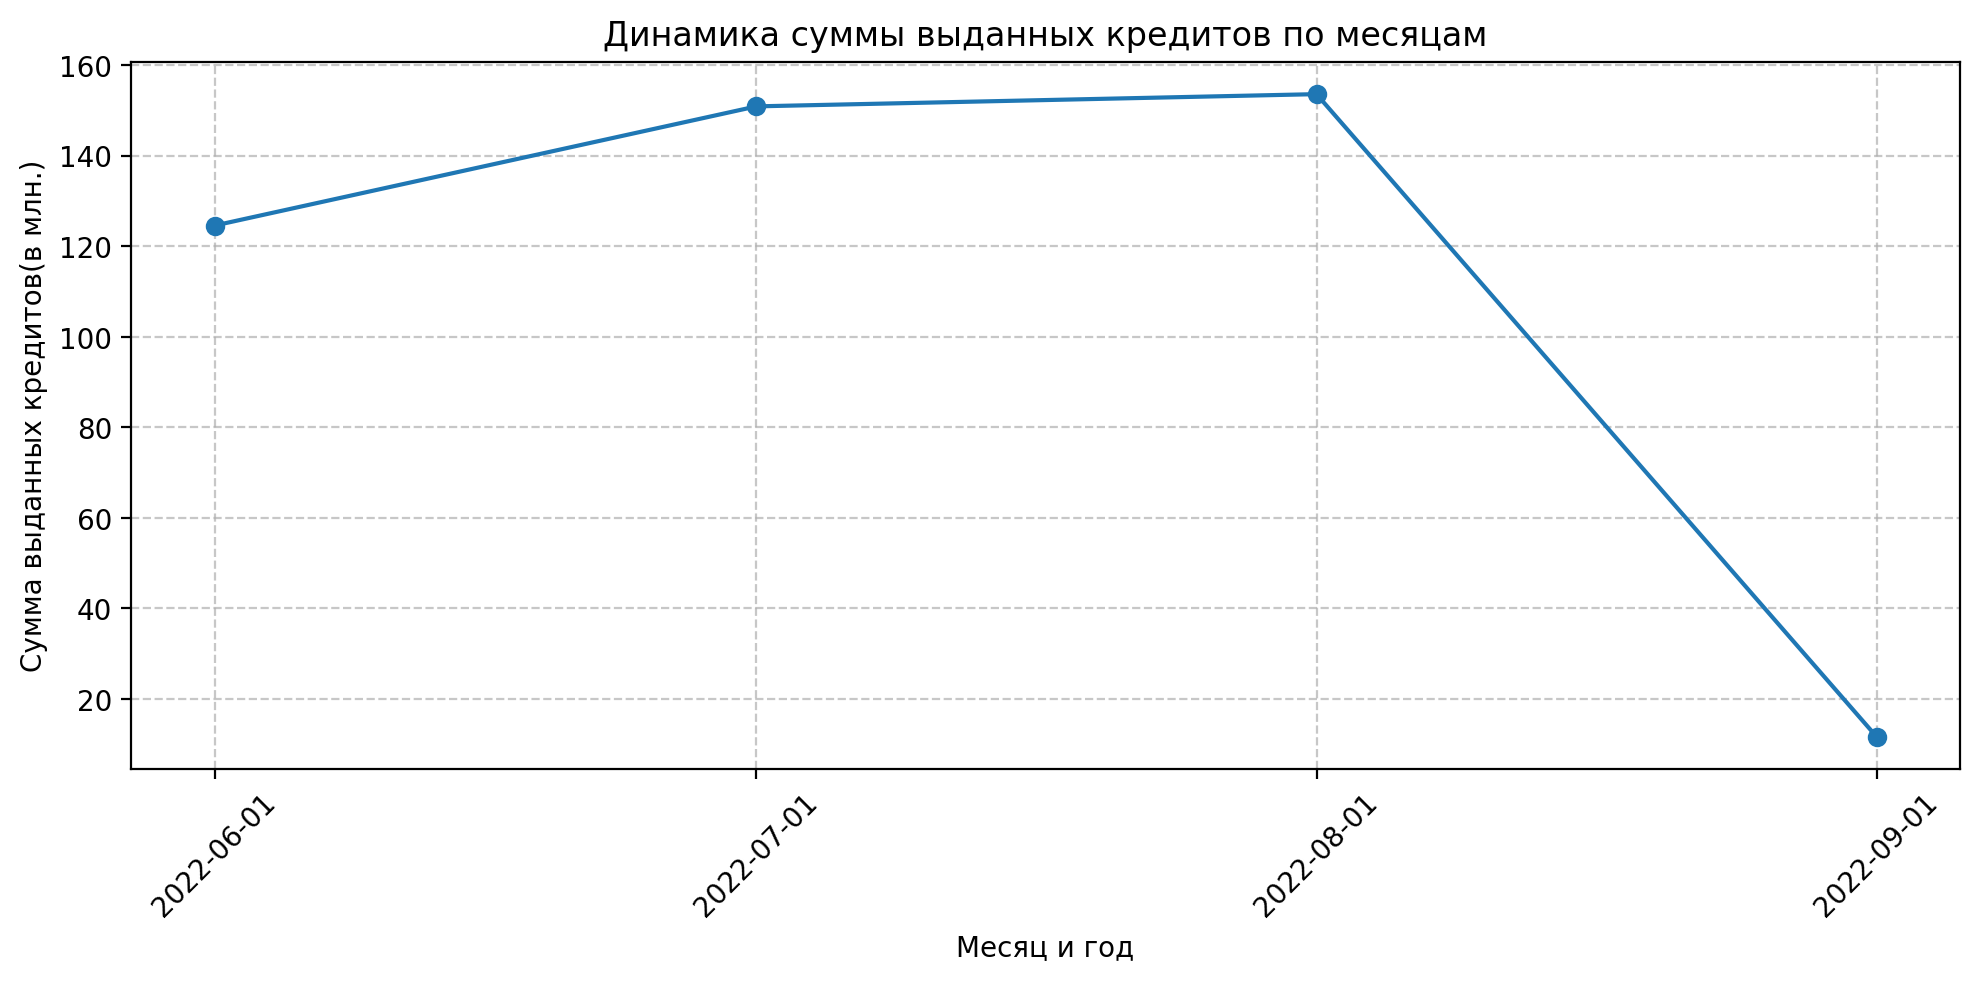

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(sum_issued_orders['month_issue'], sum_issued_orders['monthly_issued_sum'], marker='o')

plt.title('Динамика суммы выданных кредитов по месяцам', fontsize = 12)
plt.xlabel('Месяц и год')
plt.ylabel('Сумма выданных кредитов(в млн.)')
plt.xticks(sum_issued_orders['month_issue'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Динамика суммы выданных кредитов показывает схожую динамику с количеством выданных кредитов. То есть показывает резкое снижение в сентябре. Посмотрим на количество поданных заявок на кредит по месяца, возможно в этом причина резкого снижения.

In [60]:
creation_orders = orders.groupby('month_creation')['order_id'].agg('count').reset_index()
creation_orders.columns = ['month_creation','count_created_orders']

creation_orders 

,month_creation,count_created_orders
0,2022-06-01,17503
1,2022-07-01,19020
2,2022-08-01,19223


Так как зявки на кредиты подавались только до августа(влючительно) это объясняет падение показателя в сентябре. Так как разница в количестве поданных заявок не имет резких колебаний можно предположить, что бОльшая часть заявок была одобрена в течение августа, а та часть заявок которая пришла в конце августа, была одобрена в сентябре.

### 2.2. Количество и сумма плановых платежей в разрезе по месяцам

Визуализируем "ожидания" банка по поступающим платежам. Ориентируясь на датасет plan. Посмотрим количество плановых платежей и сумм в разрезе месяцев. Перед этим офильтруем все плдановые платежи до 8 декабря 2022 года - то есть на актуальную дату.

In [64]:
plan = plan[plan['plan_at'] <= '2022-12-08']

In [65]:
#количество уникальных id зявок на кредит оставшихся после фильтрации по дате
plan['order_id'].nunique()

55746

In [66]:
#группируем данные по плановым платежам для подсчетаколичества ожидаемых платежей банком по месяцам
plan_count_payment = plan.groupby('month_plan_at')['plan_at'].agg('count').reset_index()
plan_count_payment.columns = ['month','count_plan_payment']

plan_count_payment

,month,count_plan_payment
0,2022-06-01,17980
1,2022-07-01,44342
2,2022-08-01,66450
3,2022-09-01,65133
4,2022-10-01,62951
5,2022-11-01,60739
6,2022-12-01,15802


Визуализируем полученную таблицу

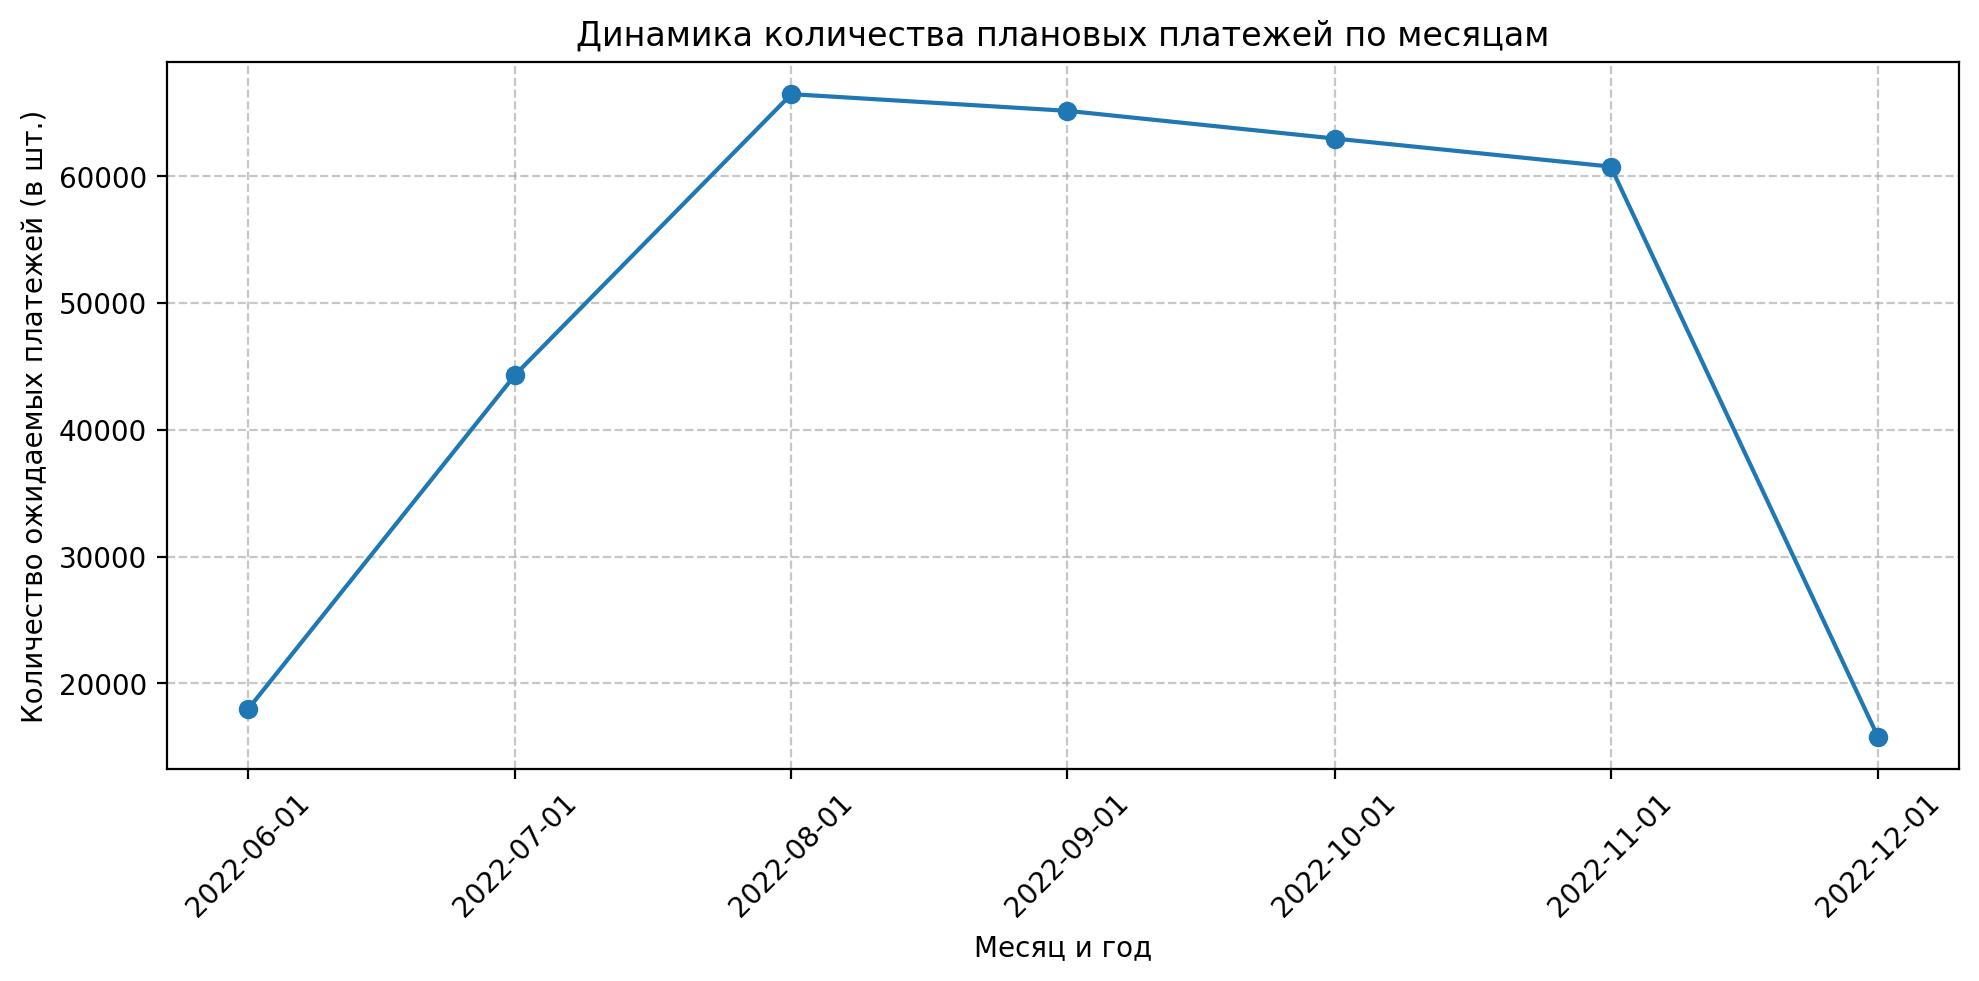

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(plan_count_payment['month'], plan_count_payment['count_plan_payment'], marker='o')

plt.title('Динамика количества плановых платежей по месяцам', fontsize = 12)
plt.xlabel('Месяц и год')
plt.ylabel('Количество ожидаемых платежей (в шт.)')
plt.xticks(plan_count_payment['month'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Резкое снижение ожидаемых платежей в декабре - объясняется тем, что в анализе только 8 декабрьских дней. 
Июнь - когда только началась выдача кредитов показываетстабильный рост ожидаемых платежей, который в агусте доходит до своего пика и далее показывает небольшие снижение объема плановых оплат. Это снижение модет говорить о том, что пользователи взявшие крети в июне быстро рассчитались со своими долгами что уменьшеило последующие ожидаемые платежи.

Чтобы определить сумму платежей, которую банк ожидал получить от клиентов в каждом месяце, преобразуем данные из формата накопленного итога (plan_sum_total) в разовые плановые платежи по месяцам.

In [71]:
#сортируем датасет plan
plan_sort = plan.sort_values(['order_id', 'plan_at'])

#вычисляем разовые платежей
plan_sort['monthly_payment'] = plan_sort.groupby('order_id')['plan_sum_total'].diff()
plan_sort['monthly_payment'] = plan_sort['monthly_payment'].fillna(plan_sort['plan_sum_total'])

# Группировка по месяцам
monthly_expected = plan_sort.groupby(plan_sort['month_plan_at'])['monthly_payment'].sum().reset_index()
monthly_expected.columns = ['month', 'expected_payment']  # Правильное переименование

#переводим в миллионы
monthly_expected['expected_payment'] = monthly_expected['expected_payment'] / 1000000

monthly_expected

,month,expected_payment
0,2022-06-01,58.597405
1,2022-07-01,146.967628
2,2022-08-01,150.852721
3,2022-09-01,104.981583
4,2022-10-01,60.254632
5,2022-11-01,54.368542
6,2022-12-01,13.819009


Визуализируем полученную таблицу на графике

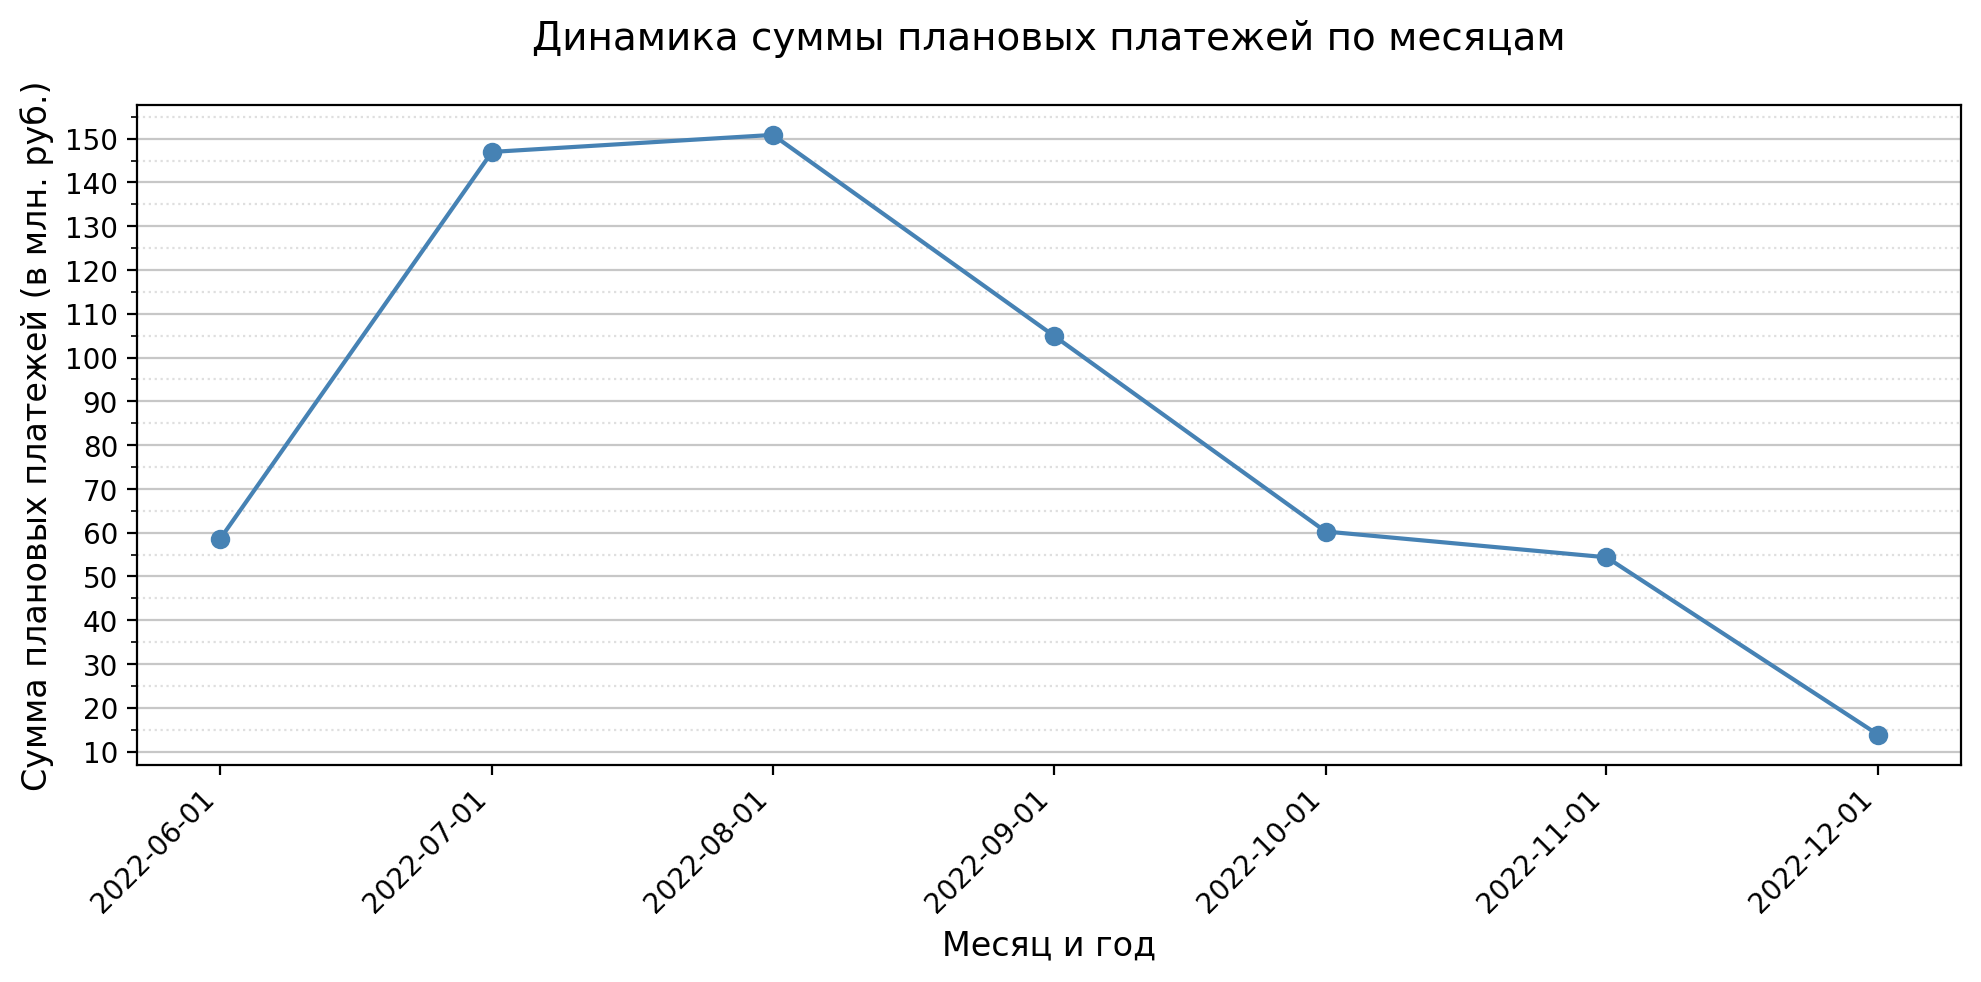

In [73]:
plt.figure(figsize=(10, 5))

# Построение графика
plt.plot(monthly_expected['month'],  monthly_expected['expected_payment'], 
         marker='o',linestyle='-',color='steelblue')

# Настройки графика
plt.title('Динамика суммы плановых платежей по месяцам', fontsize=14, pad=20)
plt.xlabel('Месяц и год', fontsize=12)
plt.ylabel('Сумма плановых платежей (в млн. руб.)', fontsize=12)

# Форматирование оси X
plt.xticks(monthly_expected['month'], rotation=45, ha='right')

# Увеличение количества делений на оси Y
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10))  # Деления каждые 10 млн
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(5))   # Дополнительные деления каждые 5 млн


plt.grid(axis='y', which='major', linestyle='-', alpha=0.7)
plt.grid(axis='y', which='minor', linestyle=':', alpha=0.4)

plt.tight_layout()
plt.show()

С июня до августа идет рост по сумме ожидаемых платежей, так же как и по количеству.
С августа и октябрь идет резкое снижение по  ожидлаемым суммамб при этом мы знаем что объем заявок по сумме кредитов с июня по август оставался примерно одинаковым.

## 2.3. Сравнение суммы фактических и запланированных платежей

Теперь посмотрим сумму фактически поступивших платежей. 

In [77]:
#шруппируем payment
monthly_fact_payment = payment.groupby('month_paid_at')['paid_sum'].agg('sum').reset_index()

#меняем названия столбцов
monthly_fact_payment.columns = ['month','sum_fact_payment']

#делим на миллион для удобного отображения значений
monthly_fact_payment['sum_fact_payment'] = monthly_fact_payment['sum_fact_payment']/ 1000000

monthly_fact_payment

,month,sum_fact_payment
0,2022-06-01,63.685587
1,2022-07-01,146.781362
2,2022-08-01,173.952480
3,2022-09-01,114.183474
4,2022-10-01,36.014133
5,2022-11-01,20.854805
6,2022-12-01,3.703001


Теперь объединим графики фактических и плановых платежей.

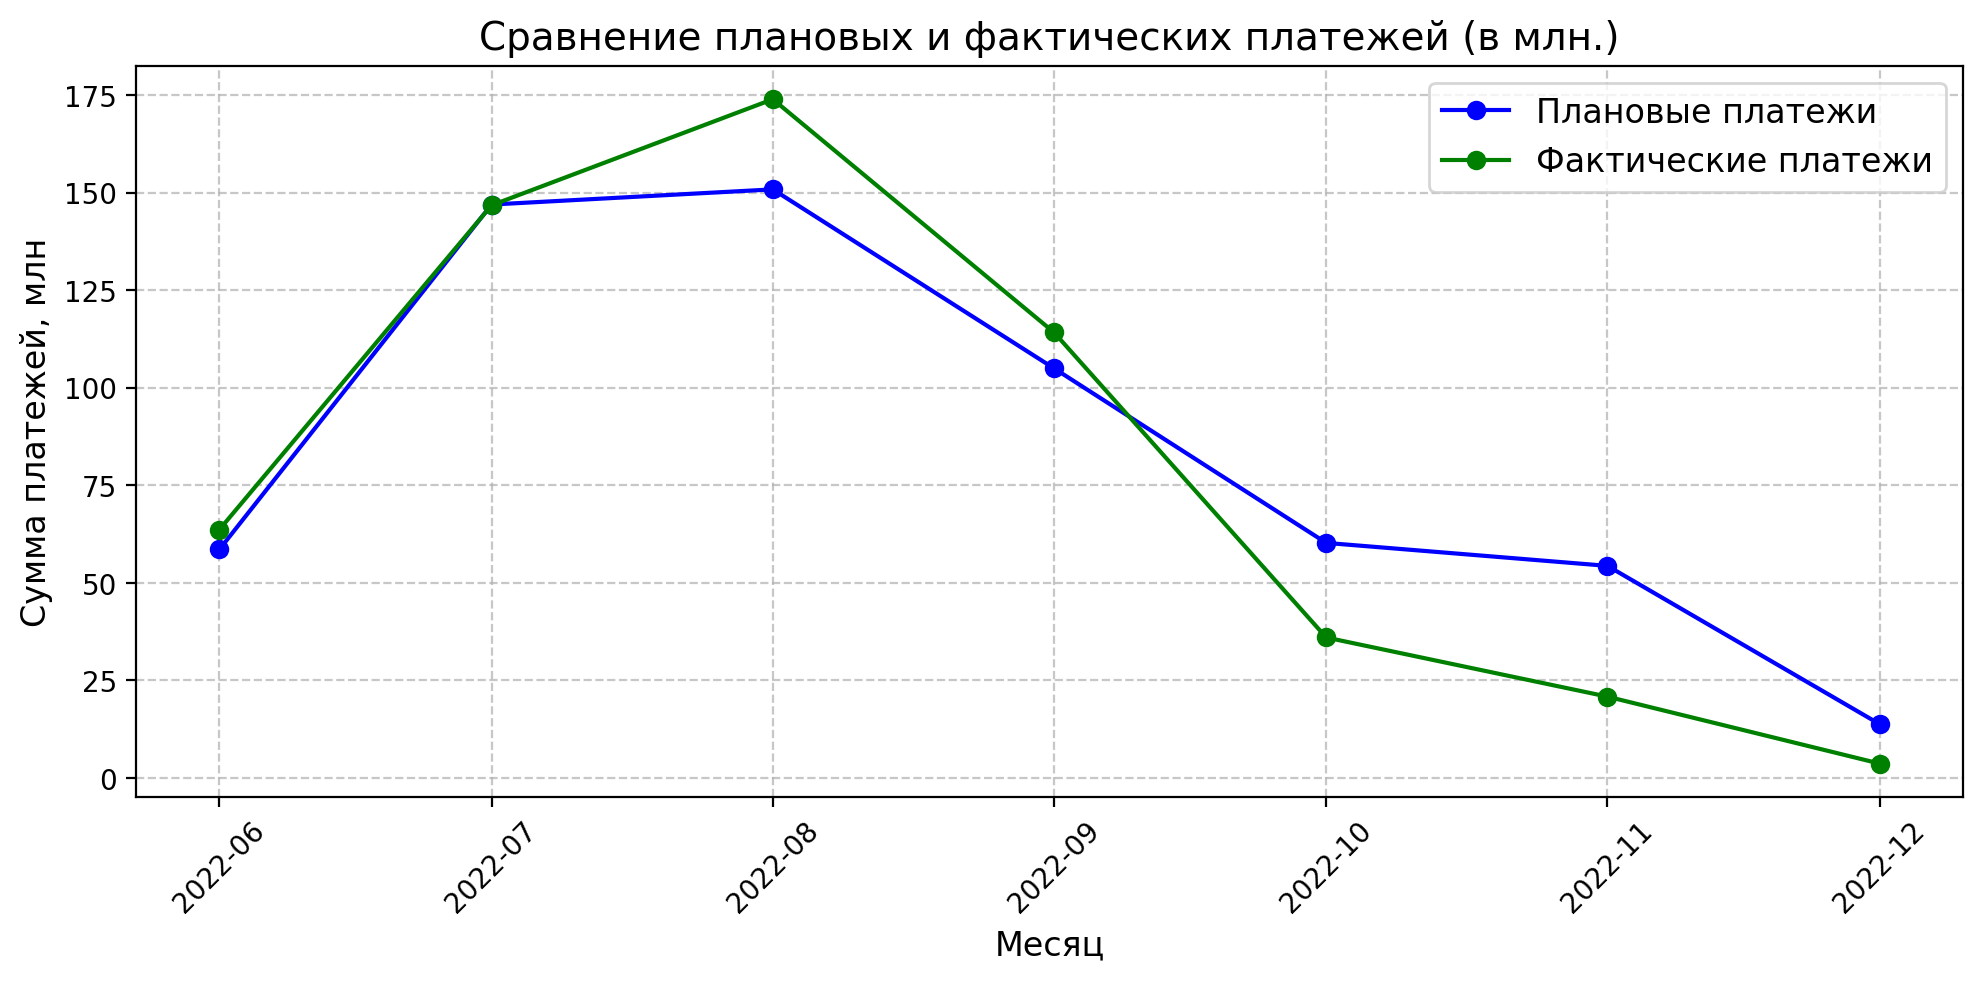

In [79]:
plt.figure(figsize=(10, 5))

#линия плановых платежей
plt.plot(monthly_expected['month'], 
         monthly_expected['expected_payment'], 
         label='Плановые платежи', marker='o', color='blue')

#линия фактических платежей
plt.plot(monthly_fact_payment['month'], 
         monthly_fact_payment['sum_fact_payment'], 
         label='Фактические платежи', marker='o', color='green')

#настройка
plt.title('Сравнение плановых и фактических платежей (в млн.)', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Сумма платежей, млн', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

***Первые 4 месяца (июнь–сентябрь)*** Фактические платежи стабильно превышали плановые (на 8–15%)
Повышение фактических платежей над плановыми говорит о внесении клиентами больших сумм для более оперативного погашения кредита. Что и дает резкое снижение плановых платежей после пика фактических.  
***Резкий спад в октябре–декабре:***
- ***Октябрь***: Недостаток платежей на 40% (24.24 млн).
- ***Ноябрь***: Провал на 61.6% (33.52 млн).
- ***1-8 декабря***: Поступления в 3.7 раза меньше плана (разница -73.2%)

Отразим разницу в ожидаемых и фактических платежей формате таблицы чтобы посмотреть на разницу в процентном и количественном отношении.

In [82]:
comparison_df = pd.merge(monthly_fact_payment, monthly_expected,
                on='month', how='outer').sort_values('month')

#рассчитываем отклонения от плана
comparison_df['deviation_mln'] = comparison_df['sum_fact_payment'] - comparison_df['expected_payment']
comparison_df['deviation_pct'] = (comparison_df['deviation_mln'] / comparison_df['expected_payment']) * 100


#форматируем показатели
comparison_df['month'] = comparison_df['month'].dt.strftime('%B').str.capitalize()
comparison_df['sum_fact_payment'] = comparison_df['sum_fact_payment'].round(2)
comparison_df['expected_payment'] = comparison_df['expected_payment'].round(2)
comparison_df['deviation_mln'] = comparison_df['deviation_mln'].apply(lambda x: f"{x:+.2f}")
comparison_df['deviation_pct'] = comparison_df['deviation_pct'].apply(lambda x: f"{x:+.1f}%")

#переименовываем столбцы
result_table = comparison_df[['month', 'sum_fact_payment', 'expected_payment', 
                'deviation_mln', 'deviation_pct']]
result_table.columns = ['Месяц', 'Факт (млн)', 'План (млн)', 
                        'Отклонение (млн)', 'Отклонение (%)']


print(result_table.to_string(index=False))

    Месяц  Факт (млн)  План (млн) Отклонение (млн) Отклонение (%)
     June       63.69       58.60            +5.09          +8.7%
     July      146.78      146.97            -0.19          -0.1%
   August      173.95      150.85           +23.10         +15.3%
September      114.18      104.98            +9.20          +8.8%
  October       36.01       60.25           -24.24         -40.2%
 November       20.85       54.37           -33.51         -61.6%
 December        3.70       13.82           -10.12         -73.2%


## 2.4. Сравнение количества фактических и запланированных платежей

In [84]:
monthly_fact_payment_count = payment.groupby('month_paid_at')['paid_at'].agg('count').reset_index()
monthly_fact_payment_count.columns = ['month','count_fact_payment']

monthly_fact_payment_count

,month,count_fact_payment
0,2022-06-01,16375
1,2022-07-01,33481
2,2022-08-01,41748
3,2022-09-01,28127
4,2022-10-01,13194
5,2022-11-01,8593
6,2022-12-01,1761


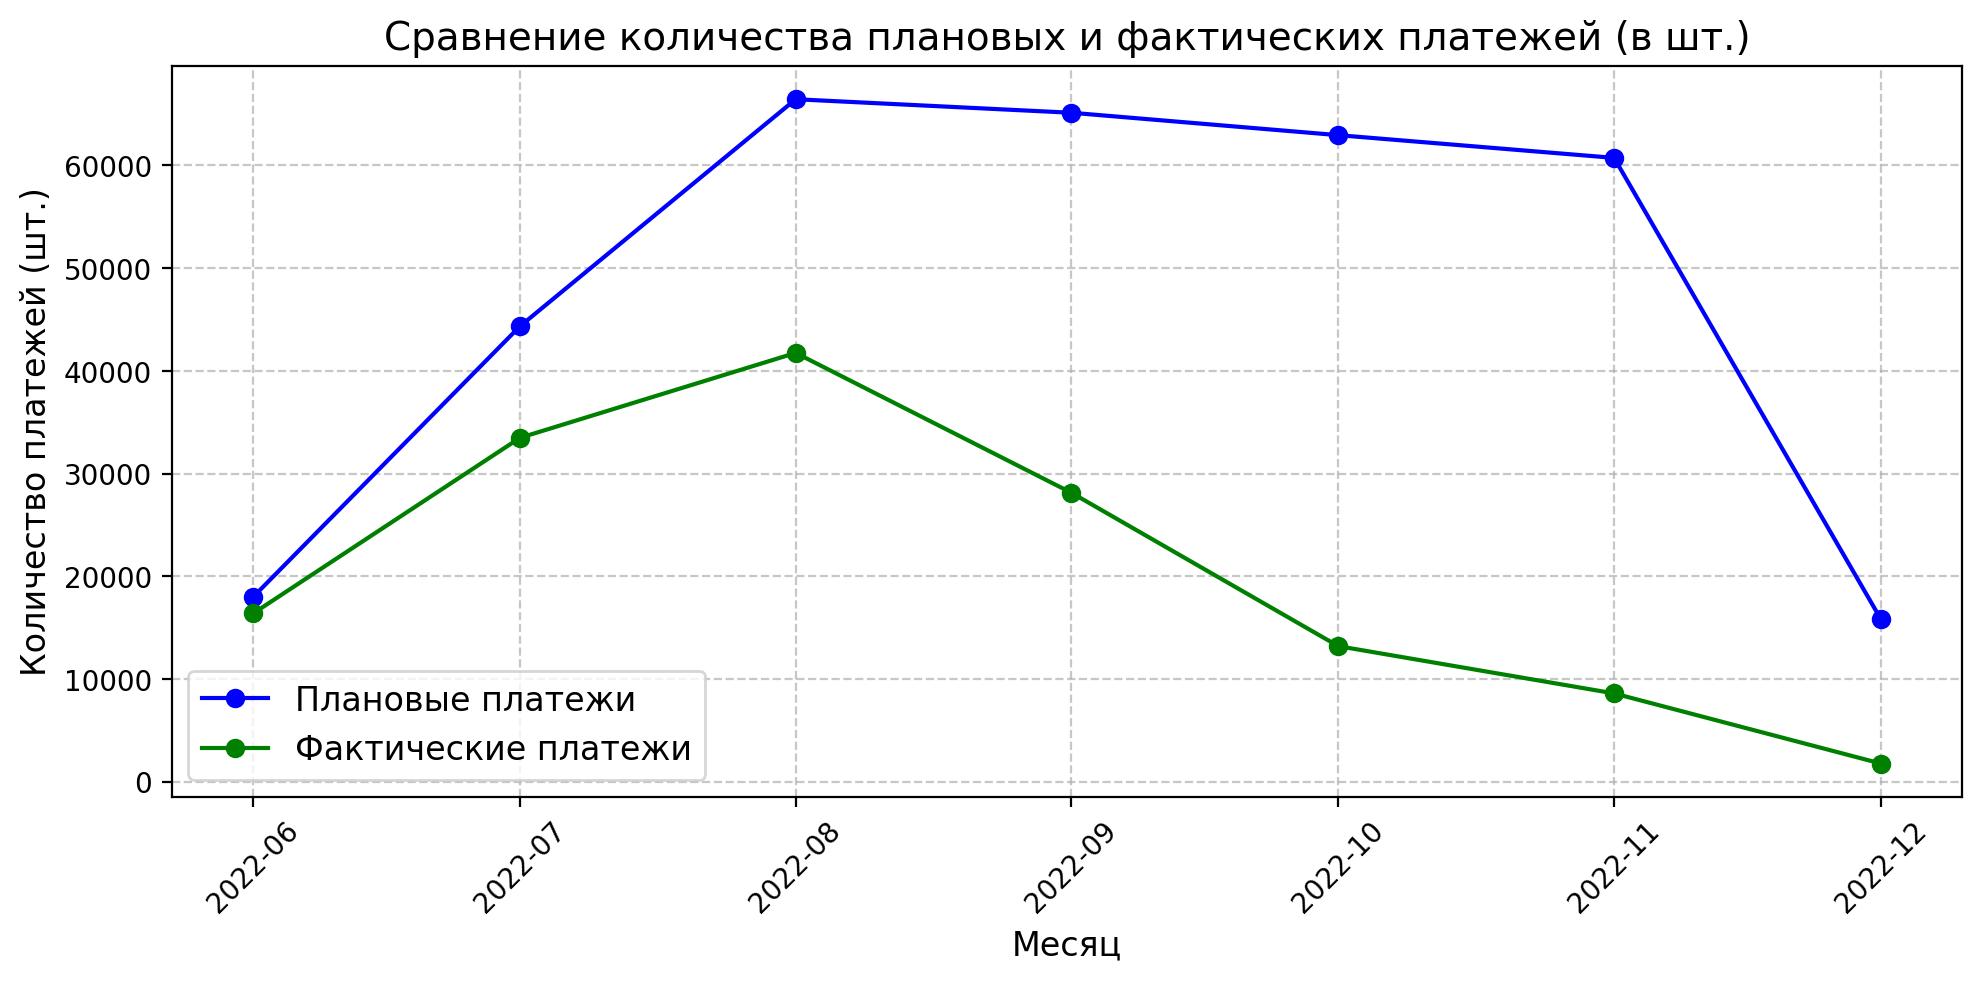

In [85]:
# Создание графика
plt.figure(figsize=(10, 5))

# Построение линии плановых платежей
plt.plot(plan_count_payment['month'], 
         plan_count_payment['count_plan_payment'], 
         label='Плановые платежи', marker='o', color='blue')

# Построение линии фактических платежей
plt.plot(monthly_fact_payment_count['month'], 
         monthly_fact_payment_count['count_fact_payment'], 
         label='Фактические платежи', marker='o', color='green')

# Настройка графика
plt.title('Сравнение количества плановых и фактических платежей (в шт.)', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Количество платежей (шт.)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

***Июнь-Август***:   
Количество платежей ниже плана, хотя при сравнение суммы платежей до августа факт опережал план — значит, поступали крупные платежи. 

***Сентябрь-Ноябрь***:  
- Падение количества на 56-89%.
- В ноябре фактическое количество платежей в 9 раз меньше плана.

Так как наши данные ограничены 8 декабря 2022 года, то не стоит говорит о снижении разрыва в декабре, так как это результат короткого временного провежутка в 8 дней и не отражает ситуацию в декабре в целом.

Таким образом ми видим тенденцию в увеличению количества просроченных платежей.

In [87]:
comparison_сount = pd.merge(monthly_fact_payment_count, plan_count_payment,
                   on='month',how='outer').sort_values('month')

#рассчитываем отклонения от плана
comparison_сount['deviation'] = comparison_сount['count_fact_payment'] - comparison_сount['count_plan_payment']
comparison_сount['deviation_pct'] = (comparison_сount['deviation'] / comparison_сount['count_plan_payment']) * 100


#форматируем показатели
comparison_сount['month'] = comparison_сount['month'].dt.strftime('%B').str.capitalize()
comparison_сount['count_fact_payment'] = comparison_сount['count_fact_payment'].round(2)
comparison_сount['expected_payment'] = comparison_сount['count_plan_payment'].round(2)
comparison_сount['deviation_mln'] = comparison_сount['deviation'].apply(lambda x: f"{x:+.2f}")
comparison_сount['deviation_pct'] = comparison_сount['deviation_pct'].apply(lambda x: f"{x:+.1f}%")

#Переименовываем столбцы
result_table_1 = comparison_сount[['month', 'count_fact_payment', 'count_plan_payment', 
                'deviation', 'deviation_pct']]
result_table_1.columns = ['Месяц', 'Факт (шт)', 'План (шт)', 
                          'Отклонение (шт)', 'Отклонение (%)']
#отображение таблицы
with pd.option_context('display.max_rows', 10, 'display.float_format', '{:,.2f}'.format):
    display(result_table_1)

,Месяц,Факт (шт),План (шт),Отклонение (шт),Отклонение (%)
0,June,16375,17980,-1605,-8.9%
1,July,33481,44342,-10861,-24.5%
2,August,41748,66450,-24702,-37.2%
3,September,28127,65133,-37006,-56.8%
4,October,13194,62951,-49757,-79.0%
5,November,8593,60739,-52146,-85.9%
6,December,1761,15802,-14041,-88.9%


Теперь мы знаем, что на протяжении всего наблюдаемого периода количество фактически поступаемых платежей всегда было ниже ожидаемого. Однако сравнение суммы платежей говорит о том, часть клиентов в период с июня по сентябрь вносили бОльшие суммы, чем предполагалось планом, поэтому в первые 3 месяца наблюдений план по сумме платежей выполнялся. 

## 2.5. Динамика количества  и объем просроченных платежей

Для присвоения статусов платежам, объединим исходные датасеты. 
Присвоим платежам 3 статуса:
- "оплачен" в случае когда на счету клиента на счету клиента есть необходимая сумма которая равна или превышает сумму планового платежа
- "отменен" статус присваивается в случае когда кредит был закрыт до наступления даты планового платежа.
- "просрочка" в случае если в дату плановго платежа на счету клиента не было достаточного количества средств.


In [91]:
#преобразуем даты (без времени)
plan['plan_date'] = pd.to_datetime(plan['plan_at']).dt.date
payment['paid_date'] = pd.to_datetime(payment['paid_at']).dt.date
orders['closed_date'] = pd.to_datetime(orders['closed_at']).dt.date

#объединяем таблицы
merged = pd.merge(plan,orders[['order_id', 'closed_date', 'issued_sum', 'put_at']],
    on='order_id', how='left')

#вычисляем ежемесячный платеж
merged = merged.sort_values(['order_id', 'plan_date'])
merged['plan_payment'] = merged.groupby('order_id')['plan_sum_total'].diff().fillna(merged['plan_sum_total'])

#обработка каждого платежа
result = []
all_order_ids = merged['order_id'].unique()

for order_id in all_order_ids:
    client_plans = merged[merged['order_id'] == order_id]
    client_payments = payment[payment['order_id'] == order_id]
    
    closed_date = client_plans['closed_date'].iloc[0] if not client_plans['closed_date'].isna().all() else None
    cumulative_paid = 0
    
    for _, plan_row in client_plans.iterrows():
        plan_date = plan_row['plan_date']
        plan_payment = plan_row['plan_payment']
        
        #присваиваем статус
        if closed_date and (plan_date > closed_date):
            status = 'Отменен'
            paid_amount = 0
        else:
            # Сумма платежей к плановой дате
            paid_by_date = client_payments[client_payments['paid_date'] <= plan_date]['paid_sum'].sum()
            available_paid = paid_by_date - cumulative_paid
            
            if available_paid >= plan_payment:
                status = 'Оплачено'
                cumulative_paid += plan_payment
                paid_amount = plan_payment
            else:
                status = f'Просрочка: {plan_payment - available_paid:.2f}'
                cumulative_paid += available_paid
                paid_amount = available_paid
        
        result.append({
            'order_id': order_id,
            'plan_date': plan_date,
            'plan_payment': plan_payment,
            'paid_amount': paid_amount,
            'status': status,
            'closed_date': closed_date,
            'issued_sum': plan_row['issued_sum'],
            'put_at': plan_row['put_at']
        })

#результат
final_result = pd.DataFrame(result)
with pd.option_context('display.max_rows', 10, 'display.float_format', '{:,.2f}'.format):
    display(final_result.head(11))

,order_id,plan_date,plan_payment,paid_amount,status,closed_date,issued_sum,put_at
0,400001732,2022-06-02,"5,600.00","5,600.00",Оплачено,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
1,400001732,2022-07-02,"3,850.00","3,850.00",Оплачено,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
2,400001732,2022-08-01,"2,720.00","2,720.00",Оплачено,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
3,400001732,2022-08-31,"2,720.00","2,720.00",Оплачено,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
4,400001732,2022-09-30,"2,720.00","2,720.00",Оплачено,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
...,...,...,...,...,...,...,...,...
6,400001732,2022-11-29,"2,720.00",0.00,Отменен,2022-10-17,"13,600.00",2022-06-02 20:18:00.180
7,400005838,2022-06-17,"23,000.00",0.00,Отменен,2022-06-02,"20,000.00",2022-06-02 15:41:33.267
8,400007915,2022-06-05,"1,820.00","1,820.00",Оплачено,2022-06-21,"5,820.00",2022-06-05 19:17:38.547
9,400007915,2022-06-20,910.00,0.00,Просрочка: 910.00,2022-06-21,"5,820.00",2022-06-05 19:17:38.547


Теперь рассчитаем количество просроченных платежей по месяца в процентном соотношении с количество ожидаемых платежей.

In [93]:
#создаем столбец с месяцем для группировки
final_result['month'] = pd.to_datetime(final_result['plan_date']).dt.to_period('M')

#считаем статистику по месяцам
stats = final_result.groupby('month').agg(
    total_plans=('plan_payment', 'count'),
    overdue_plans=('status', lambda x: x.str.contains('Просрочка').sum())).reset_index()

#процент просрочек
stats['overdue_percent'] = (stats['overdue_plans'] / stats['total_plans'] * 100).round(1)

#результат
stats.style.format({
    'total_amount': '{:,.2f}',
    'overdue_amount': '{:,.2f}',
    'overdue_percent': '{:.1f}%'
})

,month,total_plans,overdue_plans,overdue_percent
0,2022-06,17980,5222,29.0%
1,2022-07,44342,14583,32.9%
2,2022-08,66450,19664,29.6%
3,2022-09,65133,16998,26.1%
4,2022-10,62951,12105,19.2%
5,2022-11,60739,10077,16.6%
6,2022-12,15802,2391,15.1%


Виузализируем полученный резльтат и посмотрим как меняется количество просрочек в разрезе месяцев

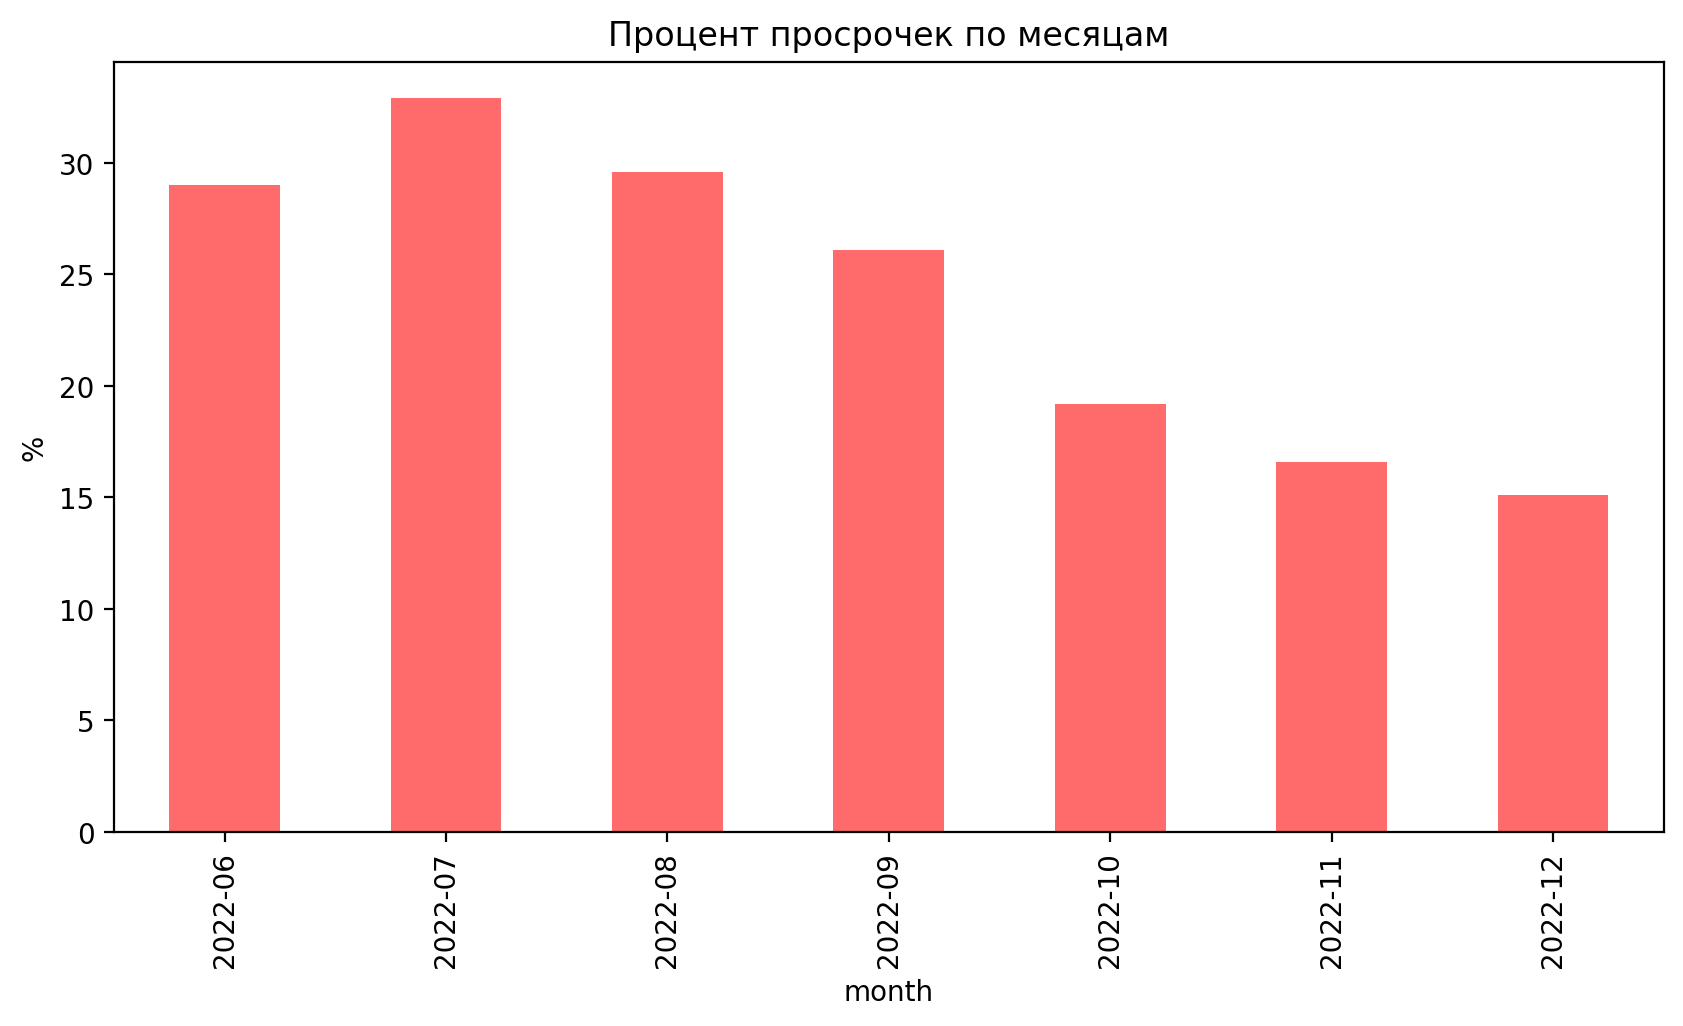

In [95]:
plt.figure(figsize=(10, 5))
stats.set_index('month')['overdue_percent'].plot(kind='bar', color='#ff6b6b')
plt.title('Процент просрочек по месяцам')
plt.ylabel('%')
plt.show()

По графику видно, что процент просроченных платежей от общего объема плановых увеличивается с 33.2% до 64.3% к первой неделе декабря.

Рассмотри объем клиентов у которых имелись просроченные платежи по месяцам, в проентном соотношении. Используем датасет созданный на предадущийх шагах final_result

In [98]:
#cоздаем столбец с месяцем
final_result['month'] = pd.to_datetime(final_result['plan_date']).dt.to_period('M')

#определеяем просрочки
final_result['is_overdue'] = final_result['status'].str.contains('Просрочка')

#группируем по месяцу и клиенту, определяем был ли у клиента хоть один просроченный платеж
monthly_client_stats = final_result.groupby(['month', 'order_id'])['is_overdue'].max().reset_index()

#статистика по месяцам
monthly_stats = monthly_client_stats.groupby('month').agg(
    total_clients=('order_id', 'nunique'),
    clients_with_overdue=('is_overdue', 'sum')
).reset_index()

#добавляем процент клиентов с просрочками
monthly_stats['overdue_percent'] = (monthly_stats['clients_with_overdue'] / 
                                   monthly_stats['total_clients'] * 100).round(1)

#результат
monthly_stats.style.format({
    'total_clients': '{:,}',
    'clients_with_overdue': '{:,}',
    'overdue_percent': '{:.1f}%'
})


,month,total_clients,clients_with_overdue,overdue_percent
0,2022-06,"12,650","4,321",34.2%
1,2022-07,"28,880","11,298",39.1%
2,2022-08,"41,267","14,886",36.1%
3,2022-09,"38,646","12,367",32.0%
4,2022-10,"34,655","8,150",23.5%
5,2022-11,"34,494","6,800",19.7%
6,2022-12,"15,802","2,391",15.1%


Визуализируем полученную таблицу

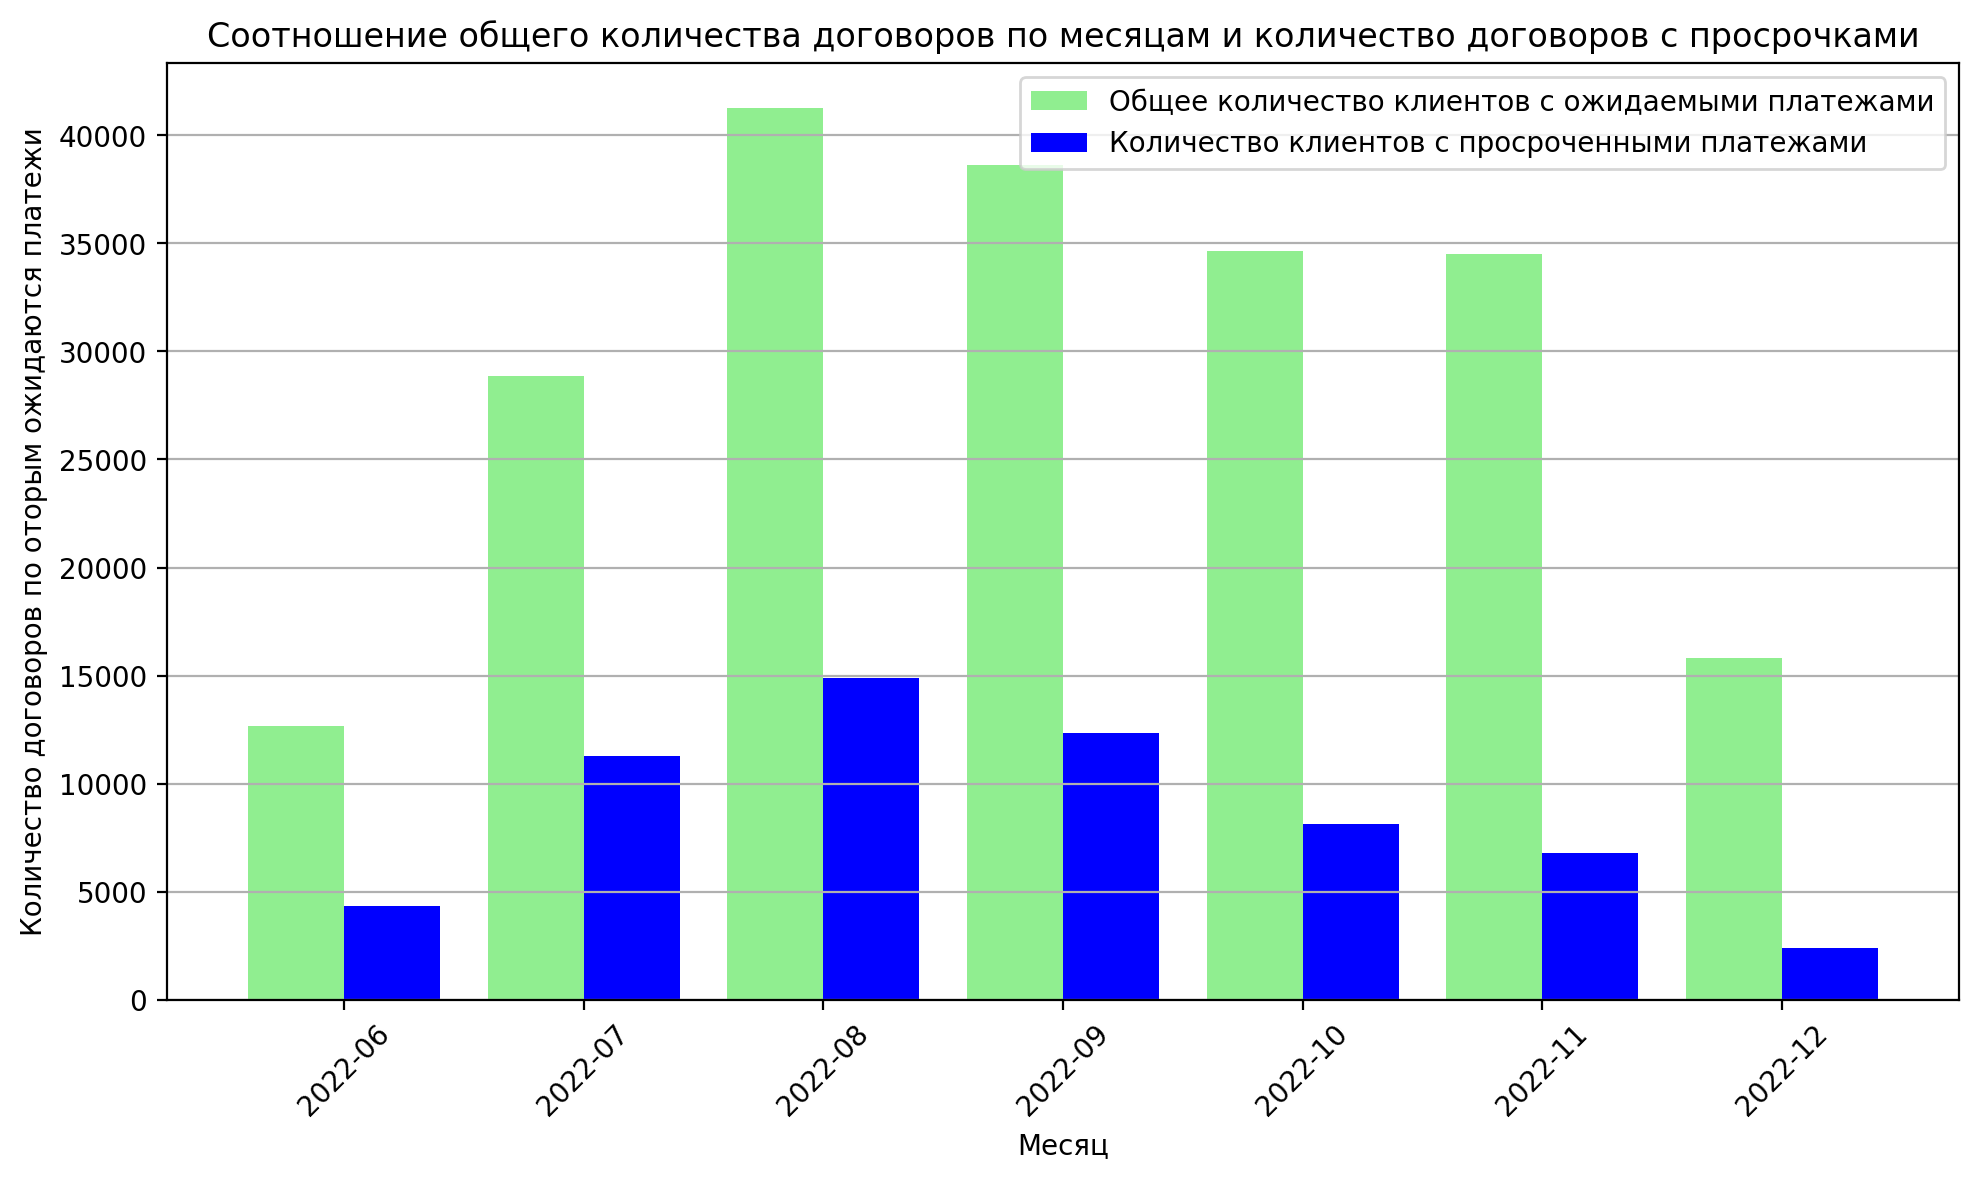

In [100]:
plt.figure(figsize=(10, 6))
x = np.arange(len(monthly_stats['month']))
width = 0.4

plt.bar(x - width/2, monthly_stats['total_clients'], width, label='Общее количество клиентов с ожидаемыми платежами', color='lightgreen')
plt.bar(x + width/2, monthly_stats['clients_with_overdue'], width, label='Количество клиентов с просроченными платежами', color='blue')

plt.title('Соотношение общего количества договоров по месяцам и количество договоров с просрочками', fontsize=12)
plt.xlabel('Месяц')
plt.ylabel('Количество договоров по оторым ожидаются платежи')
plt.xticks(x, monthly_stats['month'], rotation=45)
plt.grid(axis='y')
plt.legend()

plt.tight_layout()
plt.show()

Таким образом процент договоров по кредитам которые имеют просрочки растет с июня по июль в процентном соотношении. А далее снижается сплоть до декабря.

In [102]:
#общее количество клиентов
total_unique_clients = final_result['order_id'].nunique()

#количество клиентов с хотя бы одной просрочкой
clients_with_overdue = final_result[final_result['status'].str.contains('Просрочка')]['order_id'].nunique()

#процент клиентов с просрочками:
overdue_percent_total = (clients_with_overdue / total_unique_clients) * 100

#формируем таблицу
total_stats = pd.DataFrame({
    'Метрика': ['Всего клиентов', 'Клиентов с просрочками', 'Процент клиентов с просрочками'],
    'Значение': [
        total_unique_clients,
        clients_with_overdue,
        f"{overdue_percent_total:.1f}%"
    ]
})
#результат
display(total_stats.style.hide(axis='index'))

Метрика,Значение
Всего клиентов,55746
Клиентов с просрочками,28834
Процент клиентов с просрочками,51.7%


Взглянем на процент клиентов которые досрочно погасили свои кредиты. Для этого найдем клиентов у которых есть хотя бы один статус платежа "Отменен".

In [104]:
#группируем данные по клиентам и находим статусы
client_statuses = final_result.groupby('order_id')['status'].agg(['unique', 'count']).reset_index()
client_statuses.columns = ['order_id', 'statuses', 'total_payments']

#добавляем метки дья статусов
client_statuses['has_cancelled'] = client_statuses['statuses'].apply(lambda x: 'Отменен' in x)
client_statuses['has_overdue'] = client_statuses['statuses'].apply(lambda x: any('Просрочка' in s for s in x))

#считаем статистику
total_clients = len(client_statuses)
early_repayment_clients = client_statuses['has_cancelled'].sum()
clients_with_overdue = client_statuses[client_statuses['has_cancelled']]['has_overdue'].sum()

#процент клиентов с досрочным погашением
percentage_early_repayment = (early_repayment_clients / total_clients) * 100

#процент клиентов с досрочным погашением, у которых есть просрочки
percentage_with_overdue = (clients_with_overdue / early_repayment_clients) * 100 if early_repayment_clients > 0 else 0

#результат
print(f"Общее количество клиентов: {total_clients}")
print(f"Клиентов с досрочным погашением: {early_repayment_clients} ({percentage_early_repayment:.2f}%)")
print(f"Из них имеют хотя бы один просроченный платеж: {clients_with_overdue} ({percentage_with_overdue:.2f}%)")

Общее количество клиентов: 55746
Клиентов с досрочным погашением: 40929 (73.42%)
Из них имеют хотя бы один просроченный платеж: 17337 (42.36%)


Теперь построим общую таблице с соотношением платежей трех статусов по месяцам.

In [106]:
#добавляем столбец с месяцем к final_result
final_result['month'] = pd.to_datetime(final_result['plan_date']).dt.to_period('M')

#cоздаем упрощенный статус для группировки (без указания суммы задолженности)
final_result['status_group'] = final_result['status'].apply(
    lambda x: 'Просрочка' if isinstance(x, str) and x.startswith('Просрочка') else x
)

#группируем по месяцу и статусу
status_counts = final_result.groupby(['month', 'status_group']).size().unstack(fill_value=0)

#проверка учета всех вариантов статусом платежа
for status in ['Оплачено', 'Просрочка', 'Отменен']:
    if status not in status_counts.columns:
        status_counts[status] = 0

#рассчитываем показатели
status_counts['Всего'] = status_counts.sum(axis=1)
status_counts['% Оплачено'] = (status_counts['Оплачено'] / status_counts['Всего']) * 100
status_counts['% Просрочка'] = (status_counts['Просрочка'] / status_counts['Всего']) * 100
status_counts['% Отменен'] = (status_counts['Отменен'] / status_counts['Всего']) * 100

# Извлекаем сумму просрочки из статуса
final_result['overdue_amount'] = final_result['status'].apply(
    lambda x: float(x.split(': ')[1]) if isinstance(x, str) and x.startswith('Просрочка') else 0
)

#группируем суммы просрочек по месяцам
overdue_amounts = final_result.groupby('month')['overdue_amount'].sum().rename('Сумма просрочек')

#объединяем метрики
report = status_counts.join(overdue_amounts)
report = report[['Оплачено', '% Оплачено',
                'Просрочка', '% Просрочка', 'Сумма просрочек',
                'Отменен', '% Отменен',
                'Всего']]

#результат
print("Анализ платежей по статусам и месяцам:")
display(report.style.format({
    '% Оплачено': '{:.1f}%',
    '% Просрочка': '{:.1f}%',
    '% Отменен': '{:.1f}%',
    'Сумма просрочек': '{:,.2f}',
    'Всего': '{:,}'
}))

Анализ платежей по статусам и месяцам:


,Оплачено,% Оплачено,Просрочка,% Просрочка,Сумма просрочек,Отменен,% Отменен,Всего
month,,,,,,,,
2022-06,10518,58.5%,5222,29.0%,"16,137,912.34",2240,12.5%,"17,980"
2022-07,18524,41.8%,14583,32.9%,"30,558,812.22",11235,25.3%,"44,342"
2022-08,23393,35.2%,19664,29.6%,"35,091,897.90",23393,35.2%,"66,450"
2022-09,14739,22.6%,16998,26.1%,"24,429,820.85",33396,51.3%,"65,133"
2022-10,9712,15.4%,12105,19.2%,"11,687,545.24",41134,65.3%,"62,951"
2022-11,6356,10.5%,10077,16.6%,"8,994,965.05",44306,72.9%,"60,739"
2022-12,1241,7.9%,2391,15.1%,"1,992,540.65",12170,77.0%,"15,802"


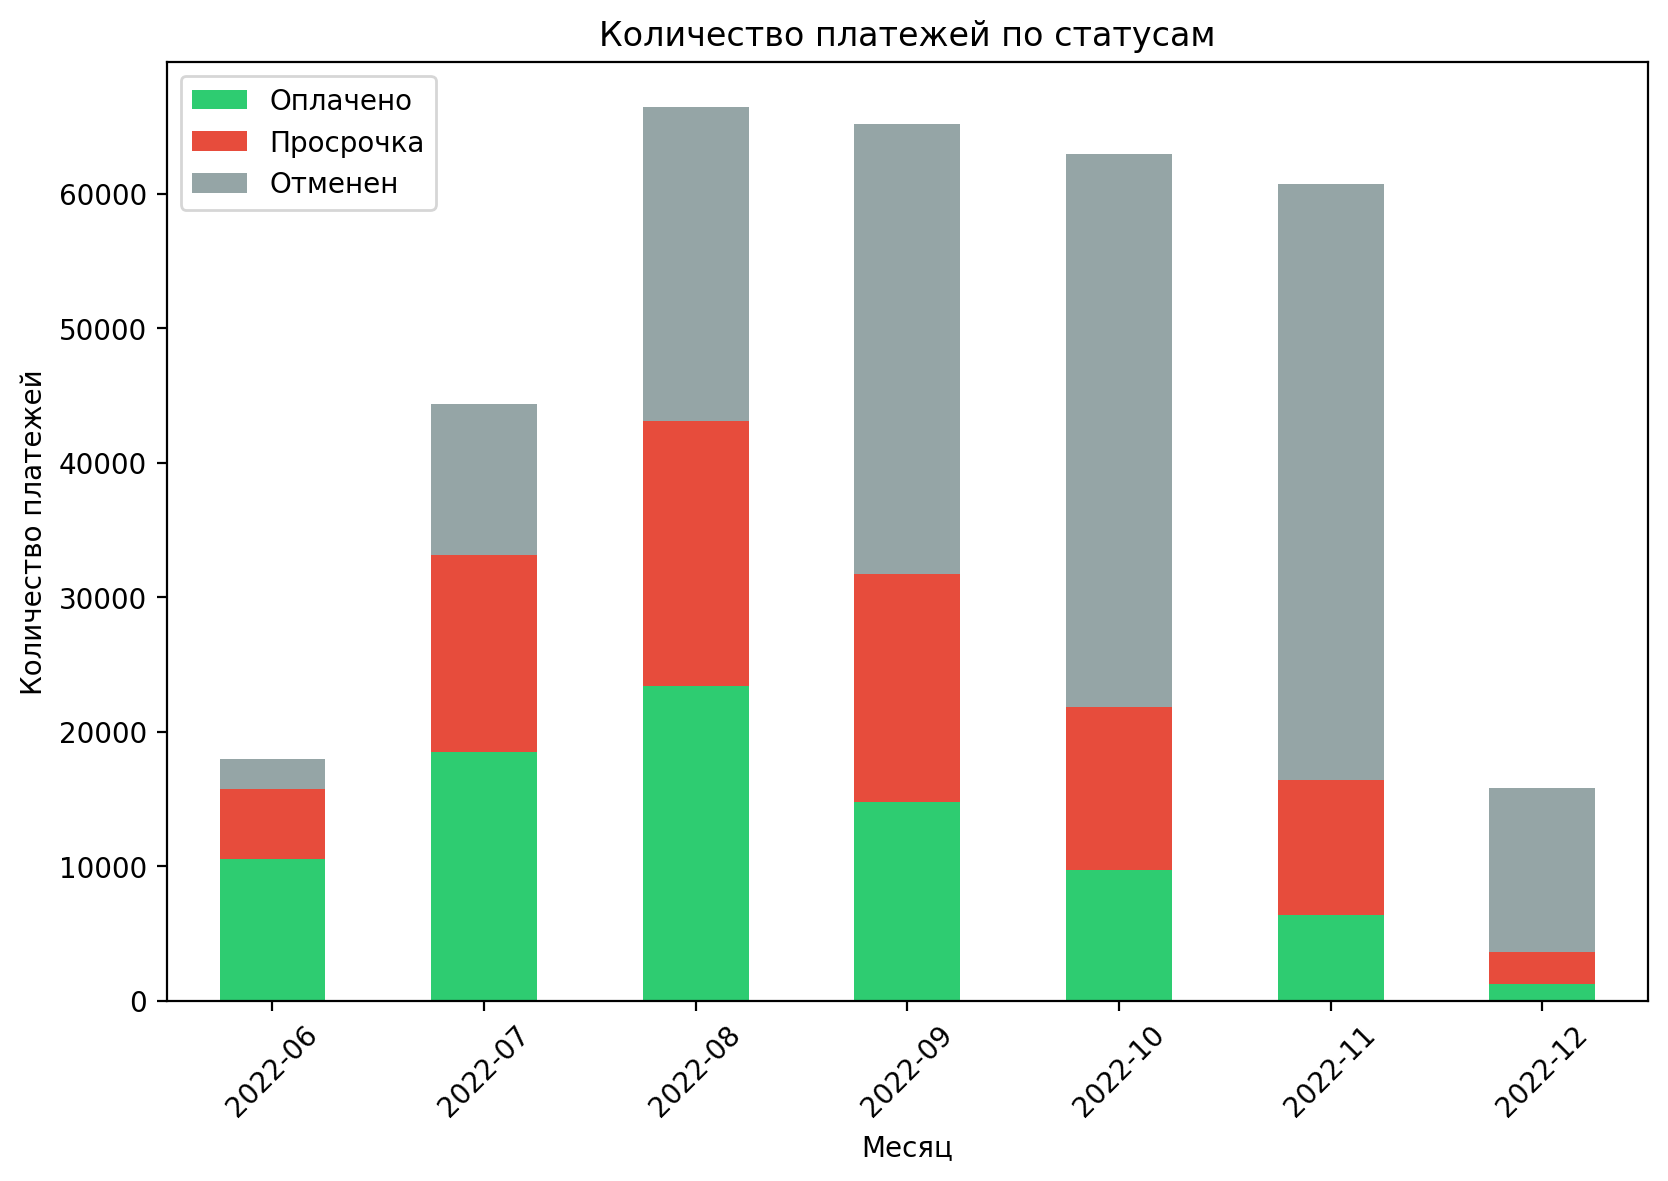

In [107]:
#визуализация
plt.figure(figsize=(16, 6))

#график количества платежей
plt.subplot(1, 2, 1)
report[['Оплачено', 'Просрочка', 'Отменен']].plot(kind='bar', stacked=True, ax=plt.gca(),
                                                 color=['#2ecc71', '#e74c3c', '#95a5a6'])
plt.title('Количество платежей по статусам')
plt.ylabel('Количество платежей')
plt.xlabel('Месяц')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 3. Общий вывод по исследованию

Для проведения исследования тенденции увеличения/снижения объема просроченных платежей получено 3 датасета от заказчика:
1. ***orders.csv*** содержит данные: 
   - order_id (номер заявки)
   - created_at (дата создания заявки)
   - put_at (дата выдачи)
   - closed_at (дата закрытия)
   - issued_sum (сумма выдачи)
2. ***payment.csv*** содержит данные: 
   - order_id (номер заявки)
   - paid_at (дата фактического платежа)
   - paid_sum (сумма фактического платежа)
3. ***plan.csv*** содержит данные: 
   - order_id (номер заявки)
   - plan_at (дата планового платежа)
   - plan_sum_total (сумма планового платежа (накопленным итогом))

На этап ***предобработки данных*** выполнены следующие шаги:
1. Изменен тип данных в столбцах с временными параметрами c object на datetime:
- в таблице orders это столбцы created_at, put_at, closed_at
- в таблице payment это столбец paid_at
- в таблице plan это столбец plan

2. Выявлено 5 строк с явными дубликатами в таблице payment и удалены из дальнейшего анализа

3. Пропуски в данных обнаружены в таблице orders в столбце closed_at 9276. После сверки с датасетов plan кредитным заявкам присвоен статус в таблице orders столбец credit_type:
- 'закрыт' - если указана дата закрытия кредита
- 'в процессе выплаты'  - если срок последнего платежа еще не наступил, то есть запланирован после 8 декабря 2022 года
- 'просрочка' - если дата последнего платежа наступила, но кредит не был закрыт.

4. Всего в полученных датасетах информация о 55748 заявках на кредит поступивших с 2 июня 2022 года по 31 августа 2022 года, что совпдает с количеством уникальных id заявок в таблице plan. Однако обнаружено, что исходя из данных таблицы payment по 2018 кредитам платежей не поступало в принципе. Из 2018 кредитов 2 оказалис уже закрытыми, обобщает эти 2 случая то, что закрытие кредитов произошло до наступления даты 1ого планового платежа, поэтому было принято рещение удалить наблюдения по этим id из всех датасетов.
   
5. Добавлены столбцы с указанием месяца для каждого датасета:
- в таблицу orders добавлены столбцы month_creation и month_issue с месяцев создания заявки и месяце выдачи кредита;
- в таблицу plan добавлены столбец month_plan_at с месяцем ожидаемого планового платежа;
- в таблицу payment добавлены столбец month_paid_at с месяцем опоступления фактического платежа.

Приступая в анализу данных мы имеем:
- 55746 заявок на кредит из которых 46470 в статусе закрыт, 8147 в процессе выплаты и 1129 у которых истекла дата последнго платежа.
- 2016 заявок по которым не зафиксировано ни одного платежа.

На этапе иследовательского анализа данных установлено:
1.  Количество заявок, количество выданных кредитов и суммы выданных кредитов с июня по сентябрь(включительно):
- ***Июнь*** поступило заявок 17503, выдано кредитов 15899, сумма выданных кредитов 124.6(млн.)
- ***Июль*** поступило заявок 19020, выдано кредитов 19085, сумма выданных кредитов 150.9(млн.)
- ***Август*** поступило заявок 19223, выдано кредитов 19330,сумма выданных кредитов 153.6(млн.)
- ***Сентябрь*** (нет поступающих зявок), выдано кредитов 1432, сумма выданных кредитов 11.6(млн.)

Показатели количества кредитов и суммы выдачи стремительно расуст с июня до июля, с июля до августа также наблюдает рост, но гораздо более медленный. К сентябрю оба показателя идут вниз так как в сентябре обрабатывались заявки конца августа.

2. Анализ динамики оджидаемых количества платежей по месяцам их суммы:  
- ***Июнь*** количество плановых платежей 17980, плановая сумма 58.6 (млн.) 
- ***Июль*** количество плановых платежей	44342, плановая сумма 147 (млн.)
- ***Август*** количество плановых платежей 66450, плановая сумма 150.8 (млн.)
- ***Сентябрь*** количество плановых платежей 65133, плановая сумма 104.9 (млн.)
- ***Октябрь*** количество плановых платежей	62951, плановая сумма 60.3 (млн.)
- ***Ноябрь*** количество плановых платежей 60739, плановая сумма 54.4 (млн.)
- ***Декабрь*** количество плановых платежей	15802, плановая сумма 13.8 (млн.)

В июне количество плановых платежей составляет 17,980, а в июле оно резко увеличивается до 44,342.  
В августе наблюдается максимальное количество плановых платежей (66,450) и высокая сумма (150.8 млн).   
В сентябре количество платежей снижается до 65,133, а сумма до 104.9 млн.   
В октябре наблюдается дальнейшее снижение до 62,951 платежей и 60.3 млн.  
В ноябре количество платежей продолжает снижаться до 60,739, а сумма — до 54.4 млн.
В декабре наблюдается резкое падение как в количестве (15,802), так и в сумме (13.8 млн). Но это следствие урезанного декабрьского периода анализа.

3. Сравнение суммы фактических и запланированных платежей:
- ***Июнь–Сентябрь*** фактические платежи стабильно превышали плановые по сумме(на 8–15%).
- ***Октябрь:*** Недостаток платежей на 40% (24.24 млн).
- ***Ноябрь:*** Провал на 61.6% (33.52 млн).
- ***1-8 Декабря***: Поступления в 3.7 раза меньше плана (разница -73.2%)

4. Сравнение количества фактических и запланированных платежей:
- ***Июнь-Август***: Количество платежей ниже плана, хотя при сравнение суммы платежей до августа факт опережал план — значит, поступали крупные платежи. 
- ***Сентябрь-Ноябрь***: Падение количества на 56-89%. В ноябре фактическое количество платежей в 9 раз меньше плана.

Рассматривая показатели количества и сумм в связке, что на всем периоде наблюдения количество фактических платежей - было всегда меньше планового, при этом с июня до августа суммы вносимых платежей превышали плановые - это говорит о том, что часть клиентов вносила бОльшие суммы для досрочного погашения кредитов, что компенсировало имеющиеся просроченные платежи.

5. Процент просроченных платежей по месяцам и клиентов имеющих просрочки:

- ***Июнь*** объем просроченных платежей 29.0%,  количество клиентов с просрочками 34.2%. 
- ***Июль*** объем просроченных платежей 32.9%, количество клиентов с просрочками 39.1%. 
- ***Август*** объем просроченных платежей 29.6%, количество клиентов с просрочками 36.1%. 
- ***Сентябрь*** объем просроченных платежей 26.1%, количество клиентов с просрочками 32.0%.   
- ***Октябрь*** объем просроченных платежей 19.2%, количество клиентов с просрочками 23.5%.  
- ***Ноябрь*** объем просроченных платежей 16.6%,количество клиентов с просрочками 19.7%. 
- ***Декабрь***объем просроченных платежей 15.1%,количество клиентов с просрочками 15.1%.   

Динамика объема просроченных платежей и договоров по кредитам показывает рост с июня до июля, а затем объем просроченных платежей  и кредитов с просрочками снижается вплоть до декабря. В общей сложности из всего объева выданных кредитов ***51.7%*** клиентов имель хоть один просроченный платеж. При этом процент договоров по которым оплата была внесена досрочно ***73.42%***.При этом ***42.36%*** клиентов их тех что досрочно погасили свои обязательства имели просроченные платежи с момента выдачи кредита до его полного погашения.

Отвечая на вопросы исследования модно отметить следующее поведение пользователей:
- количество просроченных платежей имеет общую тенденцию к снижению относительно начала периода в июне к его концу в декабре
- пик просроченных платежей наблюдается в августе и далее идет на снижение.
- стоит отметить, что клиенты имеющие просрочки, досрочно закрывают свои кредиты, что в отдельно взятом периоде перекрыввает плановую сумму платежей вне зависимости от наличия просрочек.
